In [1]:
##Import packages

import subprocess
import numpy as np
import os, sys, shutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import pandas as pd
import gc
import math
import time

from sklearn.cluster import KMeans

%matplotlib notebook

In [2]:
## Identify all water molecules
def distance(box, atom, aim_pool):
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    return distance
def findNearest(box, atom, aim_pool, num):
    """
    Find the nearest one to given atom from a group of candidate
    Input: 
        box: periodic box size
        atom: given atom (position, dimention=3d)
        aim pool: a list of positions.
    Return:
        index of closest atom in aim_pool
    
    """
    vecs = abs(np.array(aim_pool, dtype='float')-np.array(atom, dtype='float'))
    for i in range(3):
        vecs[:,i] = np.minimum(vecs[:,i],box[i]-vecs[:,i])
    distance = np.linalg.norm(vecs,axis=1)
    sorted_dis = sorted(distance)
    res = np.where(distance <= sorted_dis[num])[0]
    if len(res)>num:
        res = np.concatenate((np.where(distance < sorted_dis[num])[0],np.where(distance == sorted_dis[num])[0]))
        res = res[:num]
    return res

In [3]:
def get_O_in_OH(atoms_lines, box):
    
    pos = [[float(_e) for _e in e.split()] for e in atoms_lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
    
    Os = atoms[np.where(atoms[:,0]=='O')[0],1:]
    Hs = atoms[np.where(atoms[:,0]=='H')[0],1:]

    dis_mat = np.zeros((len(Hs), len(Os)))
    for i in range(len(Hs)):
        dis_mat[i] = distance(box, Hs[i], Os)
    dis = np.array([np.where(e == min(e))[0][0] for e in dis_mat])
    return dis

In [4]:
def _if_bond_(lines, Os, Hs, box):
    
    OH_cutoff = 1.28
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    for i in range(len(box)):
        pos[:,i] = pos[:,i]*box[i]
    
    i = 0
    l = []
    ang = []
    
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec

    def __angle(vec1, vec2):
        a = vec1/np.linalg.norm(vec1)
        b = vec2/np.linalg.norm(vec2)
        temp = np.dot(vec1, vec2)
        if temp>1:
            temp=1
        if temp<-1:
            temp=-1
        return math.acos(temp)
    
    while i < len(Os):
        _O = Os[i]
        _num = np.count_nonzero(Os == _O, axis=0)
        vec = []
        for j in range(_num):
            _i = i+j 
            _temp = np.linalg.norm(__periodic(pos[Hs[_i]]-pos[Os[_i]],box))
            if _temp <= OH_cutoff:
                l.append(1)
                vec.append(1)
            else:
                l.append(0)
                vec.append(0)
        if _num > 1:
            temp = np.zeros((_num,_num))
            for _i in range(_num):
                for _j in range(_i+1,_num):
                    ang.append(vec[_i]*vec[_j])
        i=i+_num
    return np.array(l), np.array(ang)
                    
        

In [5]:
def bond_angle(lines, Os, Hs, box):
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    for i in range(len(box)):
        pos[:,i] = pos[:,i]*box[i]
    
    i = 0
    l = []
    ang = []
    
    
    def __periodic(vec,box):
        for i,e in enumerate(vec):
            if abs(e)>box[i]/2:
                vec[i] = vec[i]-vec[i]/abs(vec[i])*box[i]
        return vec

    def __angle(vec1, vec2):
        a = vec1/np.linalg.norm(vec1)
        b = vec2/np.linalg.norm(vec2)
        temp = np.dot(vec1, vec2)
        if temp>1:
            temp=1
        if temp<-1:
            temp=-1
        return math.acos(temp)
    
    while i < len(Os):
        _O = Os[i]
        _num = np.count_nonzero(Os == _O, axis=0)
        vec = []
        for j in range(_num):
            _i = i+j
            vec.append(__periodic(pos[Hs[_i]]-pos[Os[_i]],box)) 
            l.append(np.linalg.norm(vec[-1]))
        if _num > 1:
            temp = np.zeros((_num,_num))
            for _i in range(_num):
                for _j in range(_i+1,_num):
                    ang.append(__angle(vec[_i],vec[_j]))
        i=i+_num
    return np.array(l), np.array(ang)

In [6]:
def water_form(lines, eles, box, res_type = 'idxs'):
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)
    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]
        
    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    Pinds = np.where(atoms[:,0]=='P')[0]

    Os = atoms[Oinds,1:]
    Hs = atoms[Hinds,1:]
    Ps = atoms[Pinds,1:]

    OH_cutoff = 1.28
    O_H_cutoff = 2.25   
        
    mol = []
    for i in range(len(Os)):
        temp_OH = distance(box, Os[i], Hs)
        OH_idx = np.where(temp_OH<OH_cutoff)[0]
        No_OH = len(OH_idx)
        No_O_H = len(np.where(temp_OH<O_H_cutoff)[0]) - No_OH
        t = []
        t.append(No_OH)
        t.append(No_O_H)
        doner_H = 0
        #print(i)
        for _H in OH_idx:
            temp_HO = distance(box, Hs[_H], Os)
            #print(sorted(temp_HO))
            temp_HO = np.where(temp_HO<O_H_cutoff)[0]
            doner_H += (len(temp_HO)-1)
        #print(doner_H)
        t.append(doner_H)
        mol.append(t)
    mol = np.array(mol,dtype='object')
    
    mol_type = ['']*len(Os)
    for i, wat in enumerate(mol):
        temp = ''
        if wat[0] == 3:
            temp = temp+'hydronium'
            if wat[1] == 0 and wat[2] == 3:
                temp = temp+'-AAA'
            else:
                temp = temp+'-exception'
        elif wat[0] == 2:
            temp = temp+'water'
            if wat[2] > 0:
                temp = temp+'-'+'D'*wat[2]
            if wat[1] > 0:
                temp = temp+'A'*wat[1]
        else:
            temp = '-O'
            if wat[0]>0:
                temp = temp+'H'
            temp = temp+' in H3PO4'
        if res_type == 'idxs':
            if temp not in mol_type_class:
                mol_type[i] = 5
            else:
                mol_type[i] = mol_type_class[temp]
        else:
            mol_type[i] = temp
        
    return mol_type

In [7]:
def water_form_lifetime(mol_type_time, water_form_idx = -1, water_form = 'water-DDAA'):
    
    mol_type_class = {'-OH in H3PO4':6, '-O in H3PO4':7, 'hydronium-AAA':4, 
                        'water-DDA':2, 'water-DA':0, 'water-DDAA':3, 'water-DAA':1}
    if water_form_idx == -1:
        form_idx = mol_type_class[water_form]
    else:
        form_idx = water_form_idx
    periods = []
    periods_statis = []
    for i in range(len(mol_type_time[0])):
        l = mol_type_time[:,i]
        _start=0
        _end = 0
        _if = 0
        _periods = []
        for _i, e in enumerate(l):
            if e == form_idx:
                if _if == 0:
                    _start = _i
                    _if=1
                if _if == 1:
                    _end = _i
            if e != form_idx:
                if _if == 1:
                    _period = _end - _start
                    _if=0
                    if _period > 50:
                        _periods.append([_start,_end])
                        periods_statis.append(_end - _start)
            #print(_start,_end,_if,e)
        if _if == 1:
            _period = _end - _start
            if _period > 50:
                _periods.append([_start,_end])
                periods_statis.append(_end - _start)
        #print(i,_periods)
        periods.append(_periods)
    return periods, periods_statis

In [8]:
from scipy.interpolate import make_interp_spline, BSpline

def R_k(rlist, k):
    l=len(rlist)
    working_l = np.concatenate((rlist,rlist[:k]))
    mu = np.average(working_l)
    s = np.std(working_l,ddof=1)
    working_l = (working_l-mu)/s
    res = 0
    for i in range(l):
        res+=working_l[i]*working_l[i+k]
    res = res/l
    return res
def get_freq(rlist, k):
    ts = 0.5 #fs
    l = []
    ks = np.arange(k)
    for _k in ks:
        l.append(R_k(rlist,_k))
    ks = ks*ts
    
    knew = np.linspace(ks.min(), ks.max(), 300) 
    spl = make_interp_spline(ks, l, k=5)
    l_smooth = spl(knew)
    '''
    plt.plot(ks, l)
    plt.plot(knew, l_smooth)
    plt.show()
    '''
    freq = 0
    for i in range(1,len(l_smooth)-1):
        if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
            if knew[i] >= 2:
                freq = knew[i]
                break
    if freq == 0:
        return 0, np.average(rlist)
    return np.sqrt(17/9)/freq, np.average(rlist)

from scipy.fftpack import fft, dct

def get_freq_fft(rlist, k):
    ts = 0.5 #fs
    l = []
    ks = np.arange(k)
    for _k in ks:
        l.append(R_k(rlist,_k))
    ks = ks*ts
    l = dct(rlist)[:k]
    knew = np.linspace(ks.min(), ks.max(), 300) 
    spl = make_interp_spline(ks, l, k=5)
    l_smooth = spl(knew)
    '''
    plt.plot(ks, l)
    plt.plot(knew, l_smooth)
    plt.show()
    '''
    freq = 0
    for i in range(1,len(l_smooth)-1):
        if l_smooth[i-1]<=l_smooth[i] and l_smooth[i+1]<=l_smooth[i]:
            if knew[i] >= 2:
                freq = knew[i]
                break
    if freq == 0:
        return 0, np.average(rlist)
    return np.sqrt(17/9)/freq, np.average(rlist)

In [9]:
def vib_info(sys_ind,Tem,water_form = 'water-DDAA'):
    outfile = sys_ind+'/'+Tem+"_O_form.npy"
    mol_type_time = np.load(outfile)

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds.npy")
    

    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg.npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg.npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH.npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH.npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _bondL[:,_i].T:
                _a,_b = get_freq(l, 50)
                bond_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                _a,_b = get_freq(l, 50)
                angle_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
    return np.array(bond_mat), np.array(angle_mat)
def vib_info_fft(sys_ind,Tem, label = '_02',water_form = 'water-DDAA'):
    outfile = sys_ind+'/'+Tem+"_O_form.npy"
    mol_type_time = np.load(outfile)

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds.npy")
    

    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _bondL[:,_i].T:
                _a,_b = get_freq_fft(l, 50)
                bond_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                _a,_b = get_freq_fft(l, 50)
                angle_mat.append([len(l),_a,_b])
                #print([len(l),_a,_b])
    return np.array(bond_mat), np.array(angle_mat)

In [10]:
def generate_data(Tem = 'RT',sys_ind = '00',temp_tag='_01'):
    
    Tem_tag = '' #'_RT' for RT

    if Tem == 'RT':
        Tem_tag = '_RT'
    data_path = '/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp'+Tem_tag+'/'+sys_ind
    filename = 'XDATCAR'
    
    
    ###
    #Reading File
    ###

    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    
    
    ###
    #Generating formation info
    ###
    
    
    O_H_mat = np.zeros((atom_num, atom_num))

    pos = [[float(_e) for _e in e.split()] for e in lines[1:1+atom_num]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)

    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]

    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    
    
    print('generating formation info....')
    
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        temp = get_O_in_OH(lines[i*(atom_num+1):(i+1)*(atom_num+1)],box)
        for _i, _j in enumerate(temp):
            O_H_mat[Oinds[_j], Hinds[_i]]+=1
        if i%500 == 0:
            print(i)

            
    ###
    #Generating bond info
    ###
    
    
    bond_Os, bond_Hs = np.where(O_H_mat!=0)
    bond_l = len(bond_Os)
    bond_a = 0
    for _O in set(bond_Os):
        bond_a += sum(list(range(np.count_nonzero(bond_Os == _O, axis=0))))
    bond_l = np.zeros(((int(len(lines)/(atom_num+1))), bond_l))
    bond_a = np.zeros(((int(len(lines)/(atom_num+1))), bond_a))
    
    print('generating bond/angle info....')
    
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        _x,_y = bond_angle(lines[i*(atom_num+1):(i+1)*(atom_num+1)], bond_Os, bond_Hs, box)
        bond_l[i] = _x
        bond_a[i] = _y
        if i%500 == 0:
            print(i)
    outfile = sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    np.save(outfile,bond_l)
    outfile = sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    np.save(outfile,bond_a)
    
    bond_Os, bond_Hs = np.where(O_H_mat!=0)
    bond_l = len(bond_Os)
    bond_a = 0
    for _O in set(bond_Os):
        bond_a += sum(list(range(np.count_nonzero(bond_Os == _O, axis=0))))
    bond_l = np.zeros(((int(len(lines)/(atom_num+1))), bond_l))
    bond_a = np.zeros(((int(len(lines)/(atom_num+1))), bond_a))
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        _x,_y = _if_bond_(lines[i*(atom_num+1):(i+1)*(atom_num+1)], bond_Os, bond_Hs, box)
        bond_l[i] = _x
        bond_a[i] = _y
        if i%500 == 0:
            print(i)
    outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    np.save(outfile,bond_l)
    outfile = sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    np.save(outfile,bond_a)
    
    ###
    #Generating lifetime info
    ###   
    
    print('generating formation lifetime info....')
    
    mol_type_time = np.zeros((int(len(lines)/(atom_num+1)), len(np.where(eles=='O')[0])))
    for i in range( 0,int(len(lines)/(atom_num+1)) ):
        temp = water_form(lines[i*(atom_num+1):(i+1)*(atom_num+1)], eles, box)
        mol_type_time[i] = temp
        if i%500 == 0:
            print(i)
    outfile = sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
    np.save(outfile,mol_type_time)
    outfile = sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy"
    np.save(outfile,bond_Os)
    
    

In [ ]:
for i in range(1,7):
    for e in ['LT','RT']:
        generate_data(Tem = e,sys_ind = '0'+str(i),temp_tag='_02')

In [ ]:
## Example structure
#### read structure
#data_path = '/bigdata/greaneylab/wzhan097/whoochul'
#data_path = '/bigdata/greaneylab/wzhan097/woochul'
#filename = 'H3PO4_lowT_20ps.vasp'

Tem = 'RT'
sys_ind = '00'
Tem_tag = '' #'_RT' for RT

if Tem == 'RT':
    Tem_tag = '_RT'
data_path = '/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp'+Tem_tag+'/'+sys_ind
filename = 'XDATCAR'


with open(os.path.join(data_path,filename),'r') as f:
    lines = f.readlines()
box = lines[2:5]
box =[e.split() for e in box]
box = [box[0][0],box[1][1],box[2][2]]
box = [float(e) for e in box]
lines = lines[5:]
types = lines[0].split()
temp = lines[1].split()
temp = [int(e) for e in temp]
eles = []
atom_num = sum(temp)

for _i,_j in zip(types, temp):
    eles = eles+[[_i]]*_j
eles = np.array(eles, dtype = 'object')
lines = lines[2:]

In [ ]:
data_path = '/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp'+Tem_tag+'/'+sys_ind

In [ ]:
#sys_ind = '03'
#Tem = 'RT'

outfile = sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy"
mol_type_time = np.load(outfile)
fig,_ = plt.subplots(2, 2)
fig.suptitle(sys_ind+'/'+Tem)

_,periods_statis = water_form_lifetime(mol_type_time[-2000:], water_form = 'water-DDAA')
ax1 = plt.subplot(221)
ax1.hist(periods_statis,bins=50)
ax1.set_title('water-DDAA')
#ax1.set_xlabel('lifetime(timestep)')
_,periods_statis = water_form_lifetime(mol_type_time[-2000:], water_form = 'hydronium-AAA')
ax2 = plt.subplot(222)
ax2.hist(periods_statis,bins=50)
ax2.set_title('hydronium-AAA')
#ax2.set_xlabel('lifetime(timestep)')
ax3 = plt.subplot(212)
ax3 = sns.heatmap(mol_type_time.T[70:,-2000:],cmap='RdBu_r')
plt.show()

In [36]:
#sys_ind = '03'
#Tem = 'RT'
temp_tag = '_02'
df = pd.DataFrame(data=[], 
                    index = [],
                    columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                            'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                            '-O in H3PO4'])
df_water_form_num = df
#mol_type_time = np.load(sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")
for sys_id in range(0,7):
    for e in ['LT','RT']:
        mol_type_time = np.load('0'+str(sys_id)+'/'+e+"_O_form"+temp_tag+".npy")
        form_count = [0]*8
        
        for i in range(len(mol_type_time) - 100, len(mol_type_time)):
            for _i in range(8):
                form_count[_i] += len(np.where(mol_type_time[i,:]==_i)[0])/100.0
        df = pd.DataFrame(data=[form_count], 
                          index = ['0'+str(sys_id)+'/'+e],
                          columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                                   'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                                   '-O in H3PO4'])

        #df_water_form_num = df
        df_water_form_num = df_water_form_num.append(df)
df_water_form_num

,water-DA,water-DAA,water-DDA,water-DDAA,hydronium-AAA,other transition state,-OH in H3PO4,-O in H3PO4
00/LT,1.90,1.02,9.31,25.65,14.81,1.31,41.32,30.68
00/RT,6.24,0.87,12.92,21.42,10.34,2.21,47.30,24.70
01/LT,2.50,2.78,10.15,22.50,13.50,2.57,42.93,29.07
01/RT,3.24,1.72,12.11,25.18,8.62,3.13,46.37,25.63
02/LT,1.40,1.12,9.21,29.10,11.09,2.08,45.32,26.68
02/RT,3.33,2.89,9.81,23.45,10.63,3.89,45.73,26.27
03/LT,0.42,1.50,14.35,25.13,11.55,1.05,45.29,26.71
03/RT,2.35,4.39,13.96,21.45,10.05,1.80,46.68,25.32
04/LT,2.92,4.36,9.03,25.92,9.05,2.72,45.54,26.46
04/RT,1.34,2.90,12.48,25.68,8.60,3.00,47.22,24.78


In [37]:
#sys_ind = '03'
#Tem = 'RT'
temp_tag = '_02'
df = pd.DataFrame(data=[], 
                    index = [],
                    columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                            'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                            '-O in H3PO4'])
df_water_form_lifetime = df
#mol_type_time = np.load(sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")
for sys_id in range(0,7):
    for e in ['LT','RT']:
        mol_type_time = np.load('0'+str(sys_id)+'/'+e+"_O_form"+temp_tag+".npy")
        temp=[]
        for i in range(8):
            _,_temp = water_form_lifetime(mol_type_time[-5000:], water_form_idx = i)
            temp.append(np.average(_temp))
        df = pd.DataFrame(data=[temp], 
                          index = ['0'+str(sys_id)+'/'+e], 
                          columns=['water-DA', 'water-DAA', 'water-DDA', 'water-DDAA',
                                   'hydronium-AAA', 'other transition state', '-OH in H3PO4',
                                   '-O in H3PO4'])

        #df_water_form_lifetime = df
        df_water_form_lifetime = df_water_form_lifetime.append(df)
df_water_form_lifetime

,water-DA,water-DAA,water-DDA,water-DDAA,hydronium-AAA,other transition state,-OH in H3PO4,-O in H3PO4
00/LT,307.642857,196.230769,235.378882,803.920000,696.601770,195.944444,1293.881579,586.219697
00/RT,149.685950,166.591837,175.346505,389.207171,298.331288,106.574468,915.744939,457.575188
01/LT,181.411765,203.428571,224.584158,650.480874,411.227941,148.342105,1696.077519,795.432749
01/RT,194.857143,169.141176,184.500000,453.385455,304.596899,110.307692,1172.578680,559.028037
02/LT,143.458333,132.706897,275.040936,741.026455,470.311321,124.303030,1839.636364,1000.348485
02/RT,139.509434,149.045455,183.115242,440.049430,409.777778,121.840000,1296.426036,537.219008
03/LT,176.017544,183.877551,244.693277,666.335329,441.654135,120.477273,1437.476821,599.715556
03/RT,137.133333,172.801980,197.233962,437.872000,326.280488,100.615385,1272.706897,505.507874
04/LT,251.428571,281.088608,255.672043,700.153846,600.985294,241.736842,2253.931373,898.755396
04/RT,164.485294,144.204082,191.349398,416.030928,403.857143,123.780488,1167.628272,503.444000


In [38]:
df_water_form_lifetime.to_csv('H3PO4_lifetime.csv') 
df_water_form_num.to_csv('H3PO4_ave_num.csv') 

In [39]:
df_water_form_num

,water-DA,water-DAA,water-DDA,water-DDAA,hydronium-AAA,other transition state,-OH in H3PO4,-O in H3PO4
00/LT,1.90,1.02,9.31,25.65,14.81,1.31,41.32,30.68
00/RT,6.24,0.87,12.92,21.42,10.34,2.21,47.30,24.70
01/LT,2.50,2.78,10.15,22.50,13.50,2.57,42.93,29.07
01/RT,3.24,1.72,12.11,25.18,8.62,3.13,46.37,25.63
02/LT,1.40,1.12,9.21,29.10,11.09,2.08,45.32,26.68
02/RT,3.33,2.89,9.81,23.45,10.63,3.89,45.73,26.27
03/LT,0.42,1.50,14.35,25.13,11.55,1.05,45.29,26.71
03/RT,2.35,4.39,13.96,21.45,10.05,1.80,46.68,25.32
04/LT,2.92,4.36,9.03,25.92,9.05,2.72,45.54,26.46
04/RT,1.34,2.90,12.48,25.68,8.60,3.00,47.22,24.78


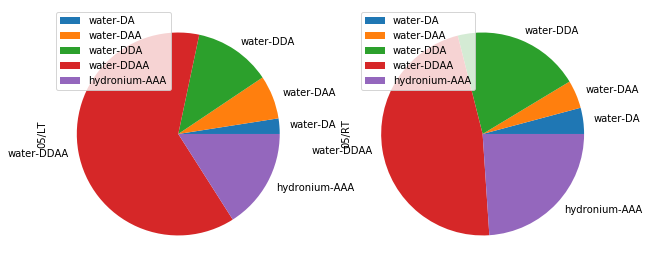

In [51]:
plot = df_water_form_num[['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']][10:12].T.plot.pie(subplots=True,figsize=(10,10))
plt.legend(loc='upper left')

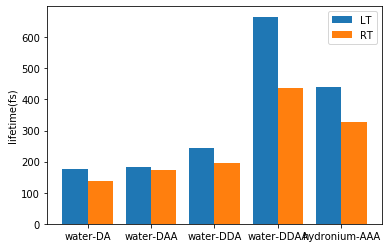

In [46]:
temp = df_water_form_lifetime[['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']][6:8]
plt.bar([i - 0.2 for i in range(5)], temp.iloc[0],label = 'LT',width=0.4)           
plt.bar([i + 0.2 for i in range(5)], temp.iloc[1],label = 'RT',width=0.4)        
plt.xticks([i for i in range(5)],['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA'])
plt.ylabel('lifetime(fs)')
plt.legend()

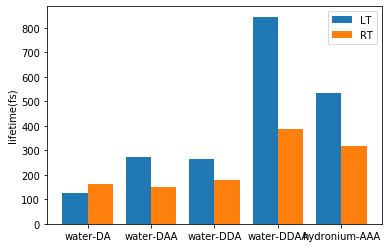

In [47]:
temp = df_water_form_lifetime[['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']][10:12]
plt.bar([i - 0.2 for i in range(5)], temp.iloc[0],label = 'LT',width=0.4)  
plt.bar([i + 0.2 for i in range(5)], temp.iloc[1],label = 'RT',width=0.4)  
plt.xticks([i for i in range(5)],['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA'])
plt.ylabel('lifetime(fs)')
plt.legend()

In [51]:

sys_ind = '00'
Tem = 'RT'
temp_tag='_02'
mol_type_time = np.load(sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")

period,_ = water_form_lifetime(mol_type_time, water_form = 'water-DAA')
Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy")
    

angles_tag = []
for i in set(Os):
    n = len(np.where(Os==i)[0])
    _n = 0
    for _i in range(n):
        _n+=_i
    angles_tag +=[i]*_n
angles_tag = np.array(angles_tag)

outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
if_OH_bond = np.load(outfile)
outfile = sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
if_HOH_angle = np.load(outfile)
outfile = sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
OH_bond = np.load(outfile)
outfile = sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
HOH_angle = np.load(outfile)
bond_mat = []
angle_mat = []
bond_list = []
angle_list = []
for i,ps in enumerate(period):
    #print(i)
    for p in ps:
        _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
        _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
        _i = np.where(_flg[0]==1)[0]
        
        for l in _bondL[:,_i].T:
            bond_list.append([i,l])
        
        _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
        _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
        _i = np.where(_flg[0]==1)[0]
        for l in _angleA[:,_i].T:
            angle_list.append([i,l])

In [52]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [53]:

#DDAA:284880,45042
bond_list = np.array(bond_list)
period_len = np.array([len(e) for e in bond_list[:,-1]])
min(period_len) , max(period_len),sum(period_len)

(51, 709, 45042)

In [54]:
np.where((period_len<1000) & (period_len>300))

#ranges = [[0,500],[500,1000],[1000,3000],[3000,5000],[5000,20000]]  #DDAA
ranges = [[0,80],[80,200],[200,500],[500,1000]]   #DAA
dp_idx=[]
for r in ranges:
    t = np.where((period_len<r[-1]) & (period_len>r[0]))[0]
    t = list(np.random.choice(t, 3))
    dp_idx=dp_idx+t
dp_idx

[49, 76, 223, 138, 124, 210, 70, 188, 166, 113, 195, 66]

In [56]:
light_c = 29979245800   #cm/s

/rhome/wzhan097/bigdata/.conda/envs/ML_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


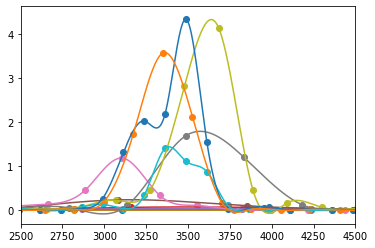

In [22]:
from scipy import interpolate
#plt.figure(figsize=(15,5))
x_int = np.linspace(2500, 4500, 20000)
y_int = np.zeros(x_int.shape,dtype='float64')
for idx in dp_idx:#range(len(period_len)):
    temp_data=bond_list[idx,1]  
    vel = temp_data[1:]-temp_data[:-1]
    fft = np.fft.fft(vel)
    ps = fft*np.conjugate(fft)
    acf = np.fft.ifft(ps)

    signal = vel #divide by maximum abs(vel)
    fourier = np.fft.fft(signal)
    n = signal.size
    timestep = 1E-3
    freq = 2*np.sqrt(17/9)*np.fft.fftfreq(n, d=timestep)

    w_length = (freq*1e12)/light_c #
    fqnew = np.linspace(0, freq.max(), 300)
    f = interpolate.interp1d(w_length, ps, kind="cubic")
    y_int=np.array(f(x_int),dtype='float64')
    plt.scatter(w_length,ps,label=str(period_len[idx]))
    plt.plot(x_int,f(x_int),label=str(period_len[idx]))
plt.xlim(2500,4500)
#plt.legend()
plt.savefig('plot/DDAA/'+'RT_02_allinone'+'.png')


<IPython.core.display.Javascript object>


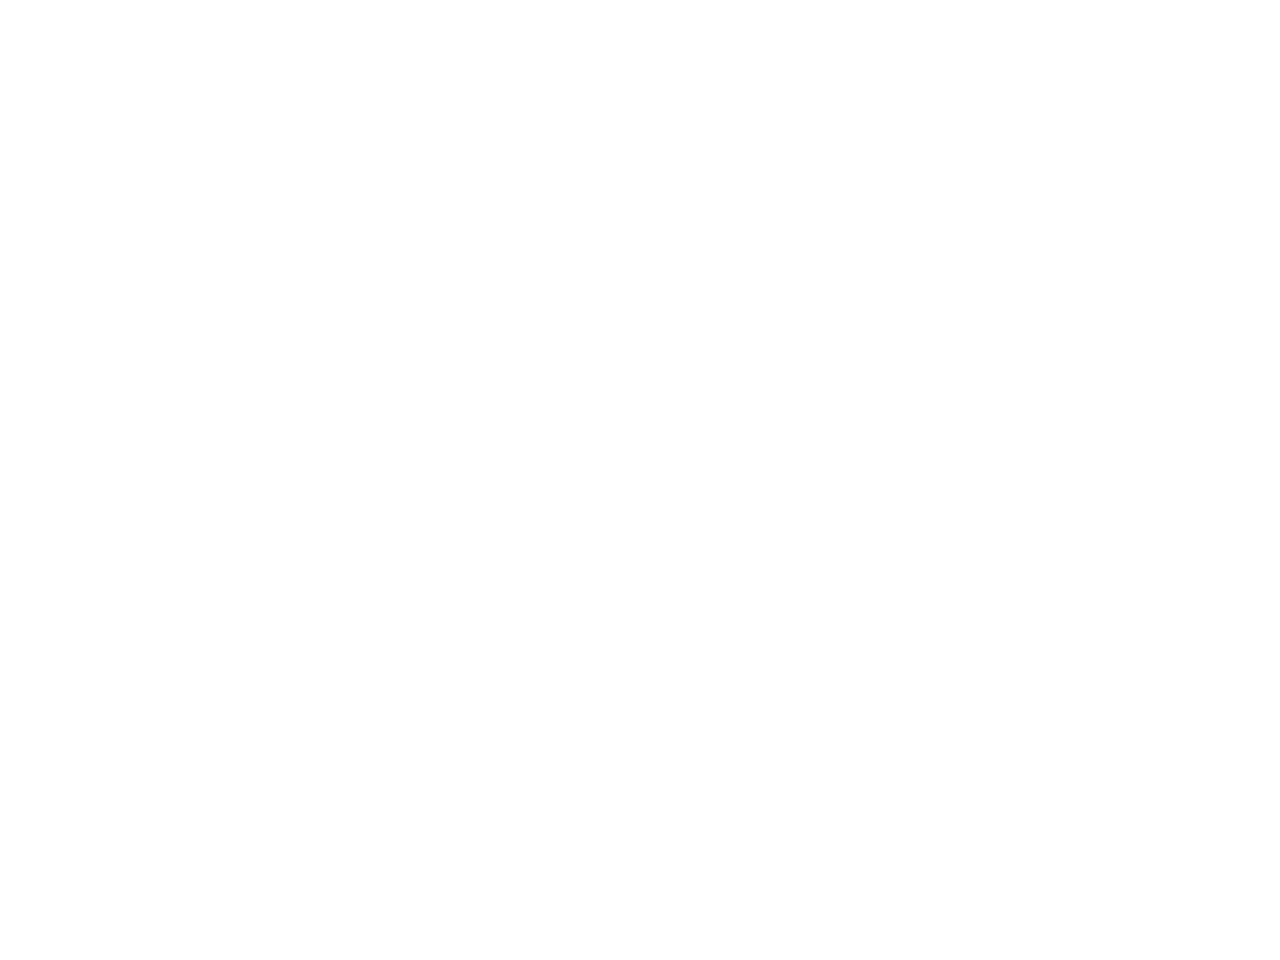

<IPython.core.display.Javascript object>


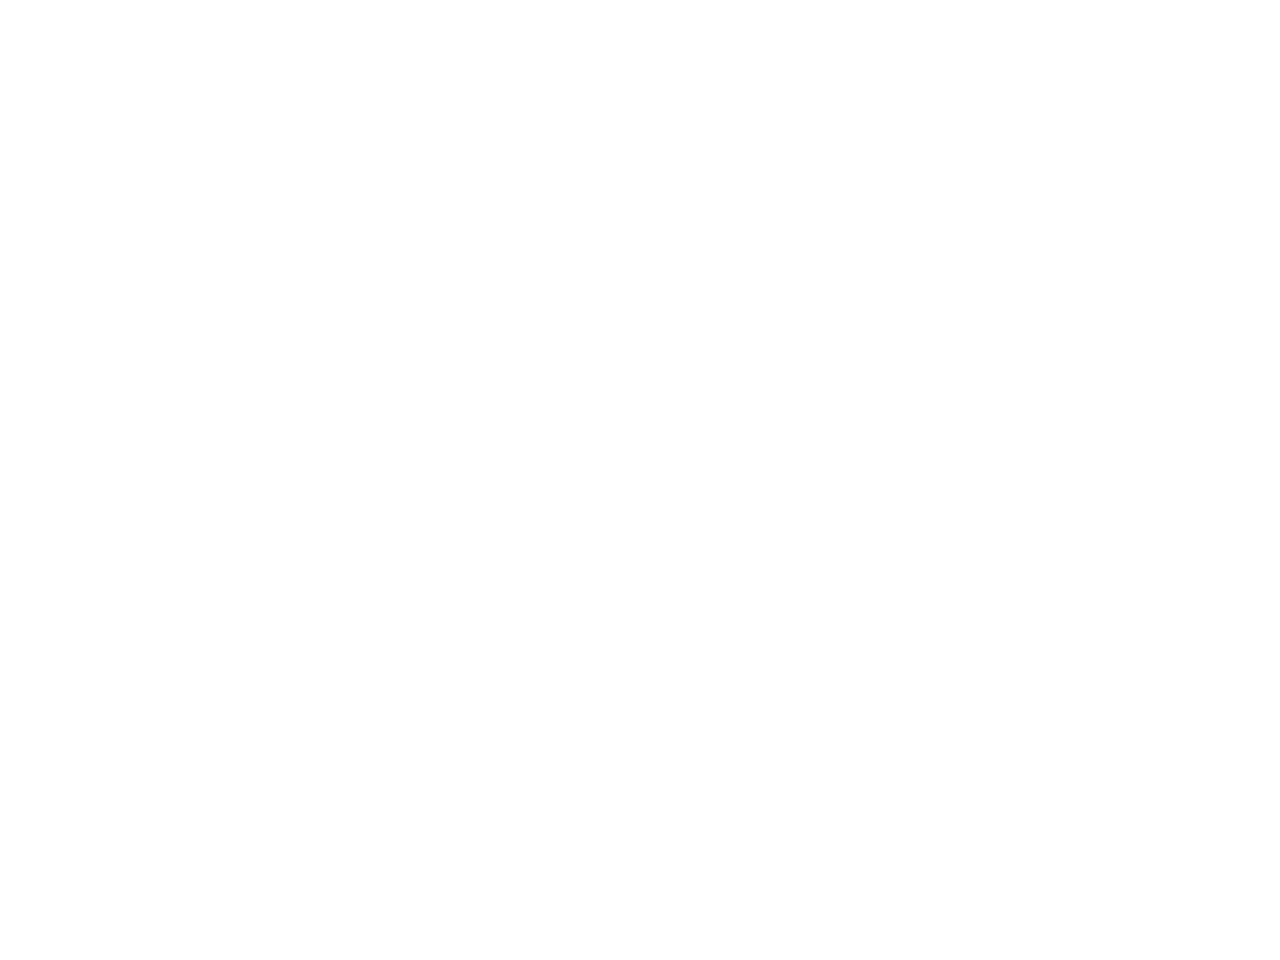

<IPython.core.display.Javascript object>


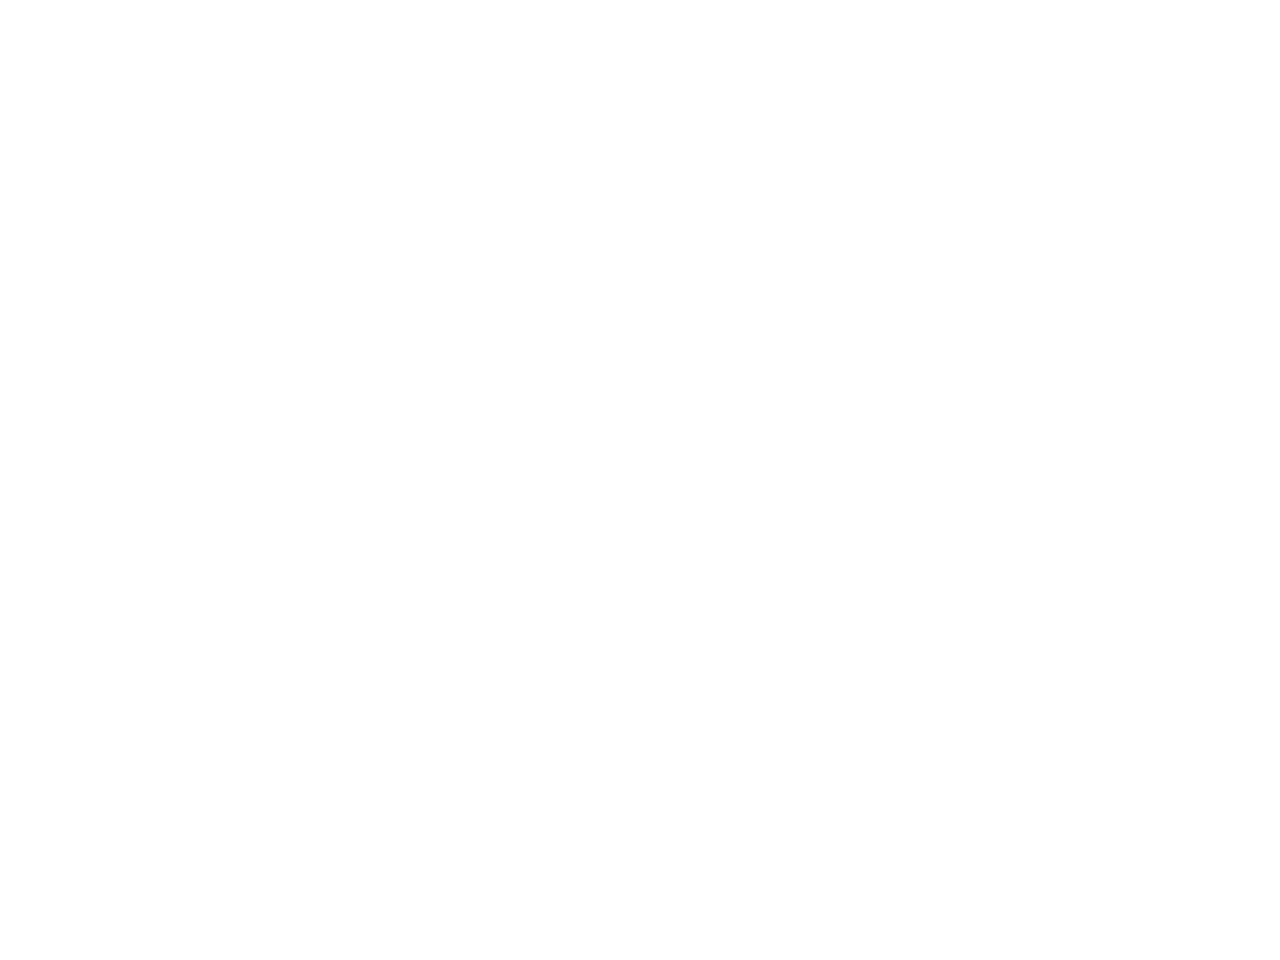

<IPython.core.display.Javascript object>


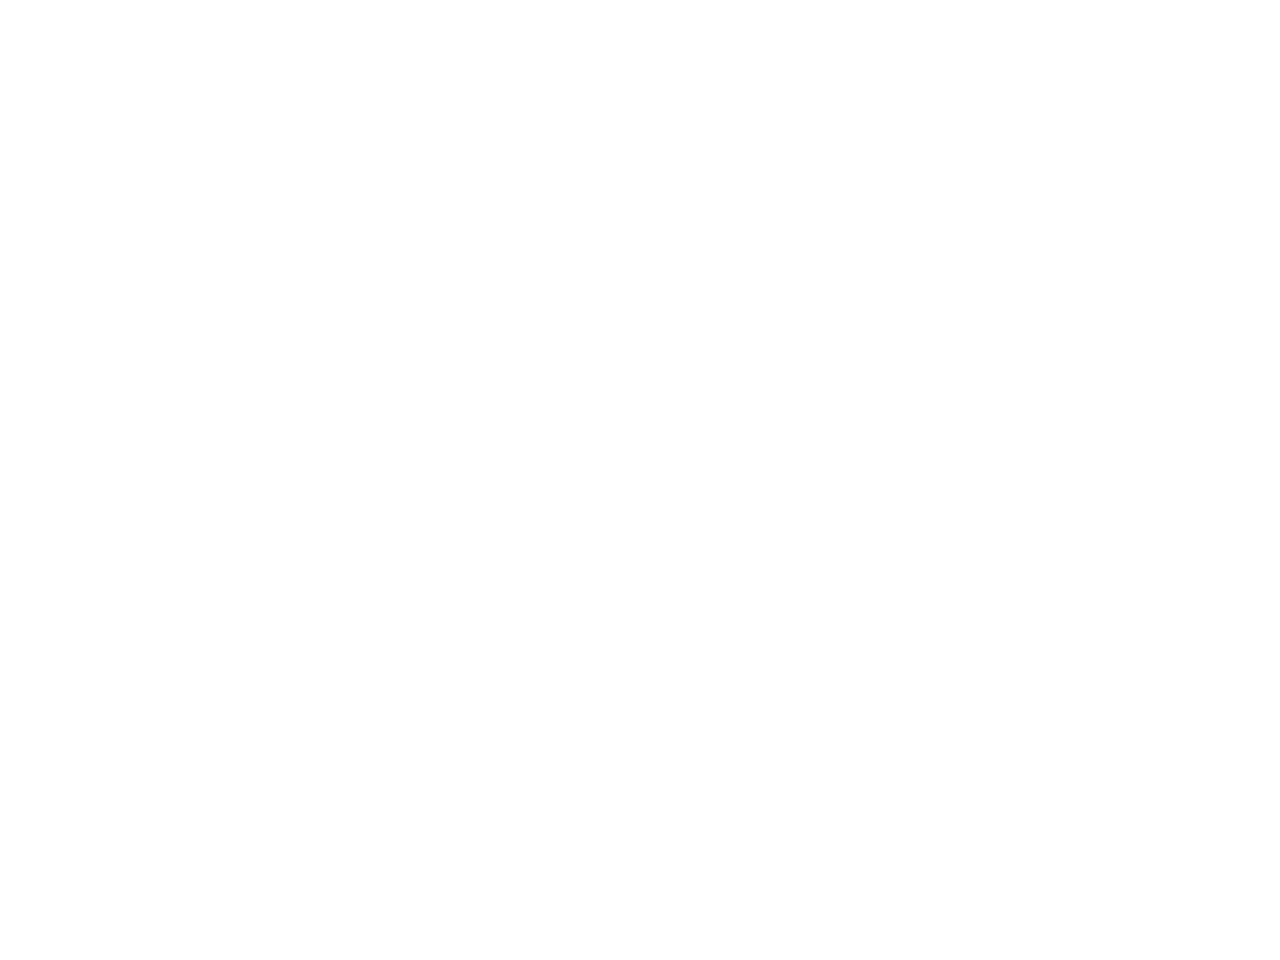

<IPython.core.display.Javascript object>


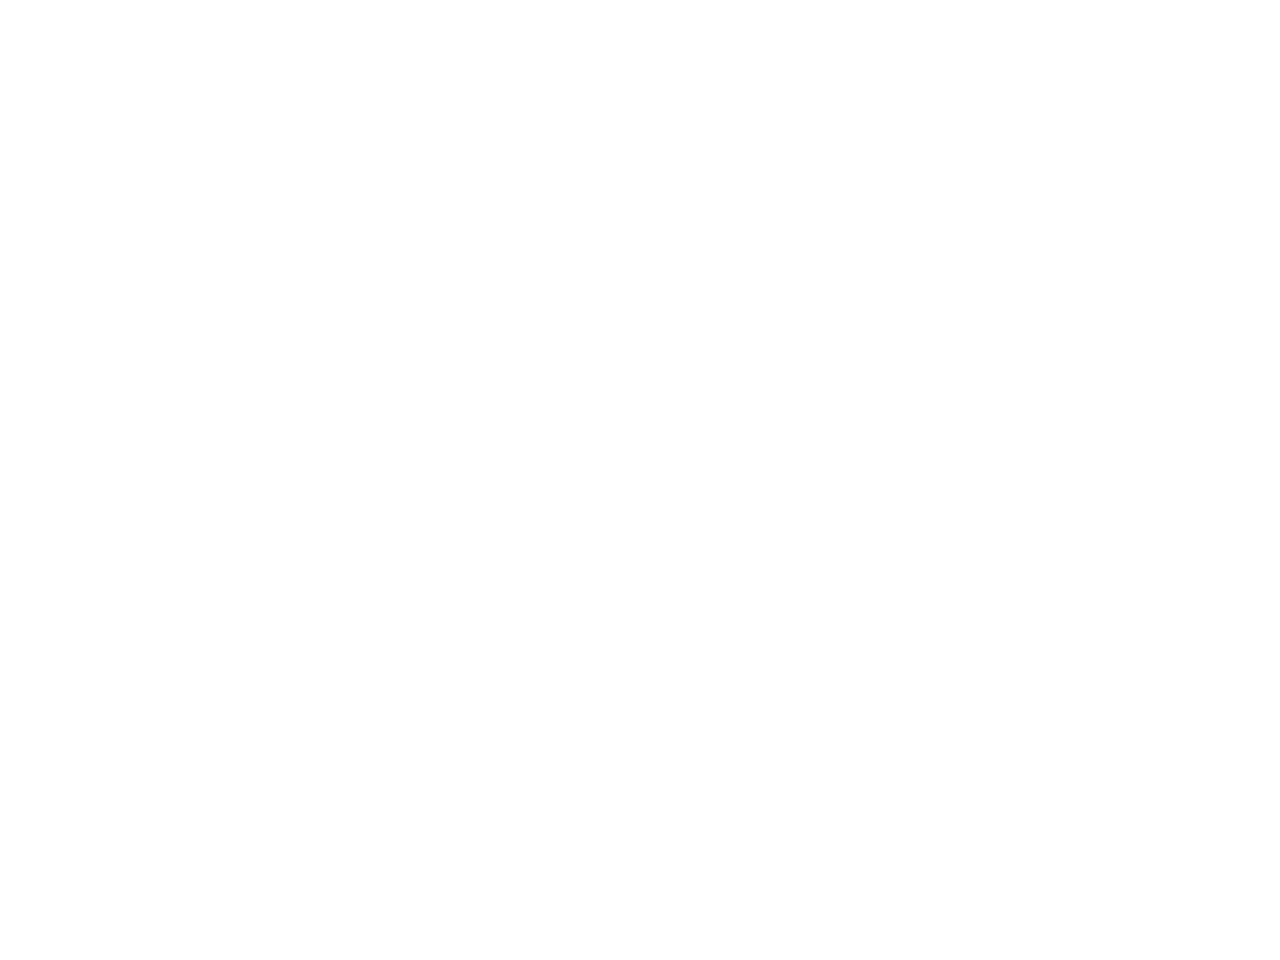

<IPython.core.display.Javascript object>


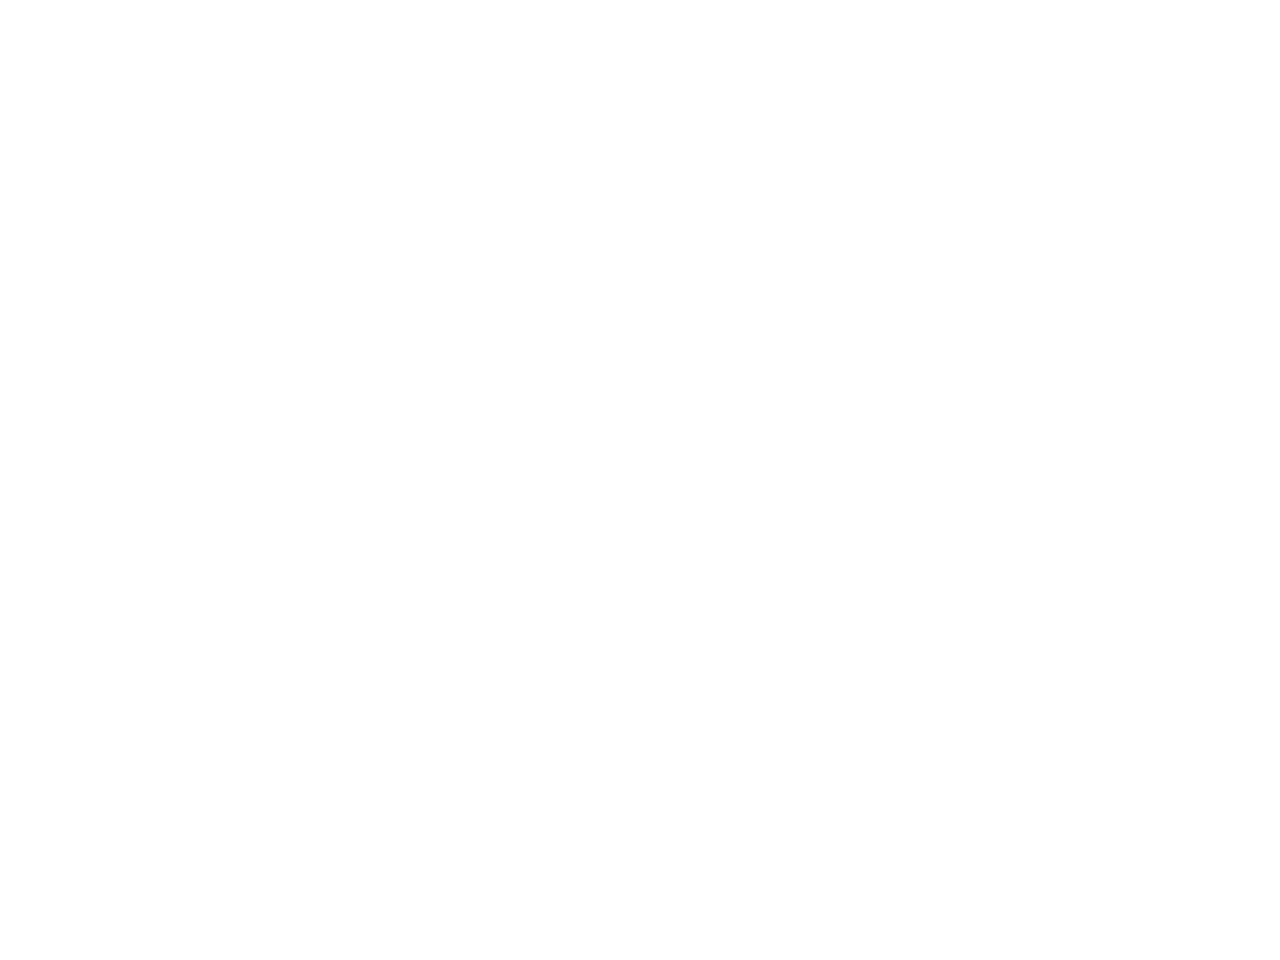

<IPython.core.display.Javascript object>


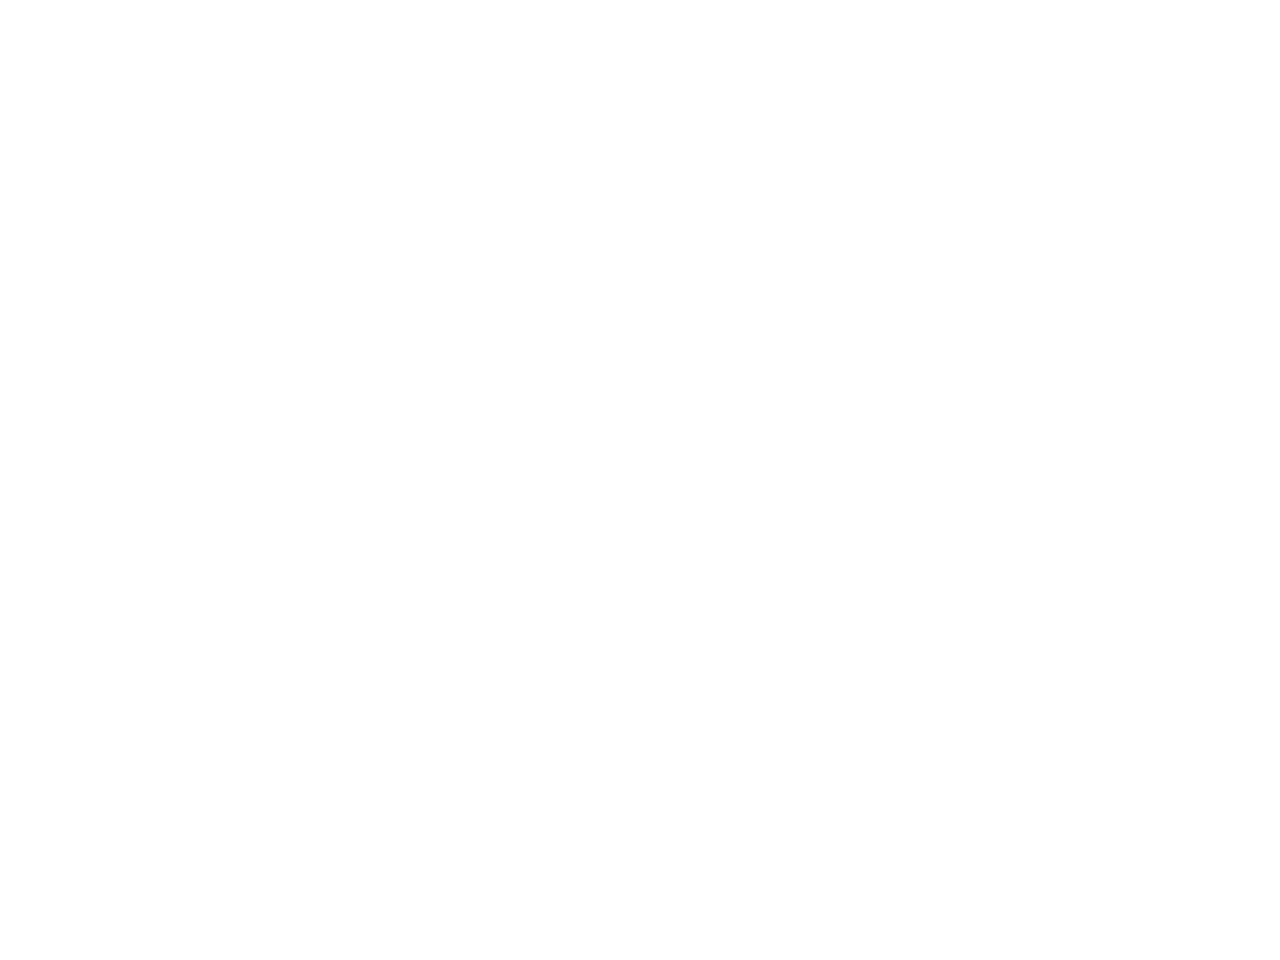

<IPython.core.display.Javascript object>


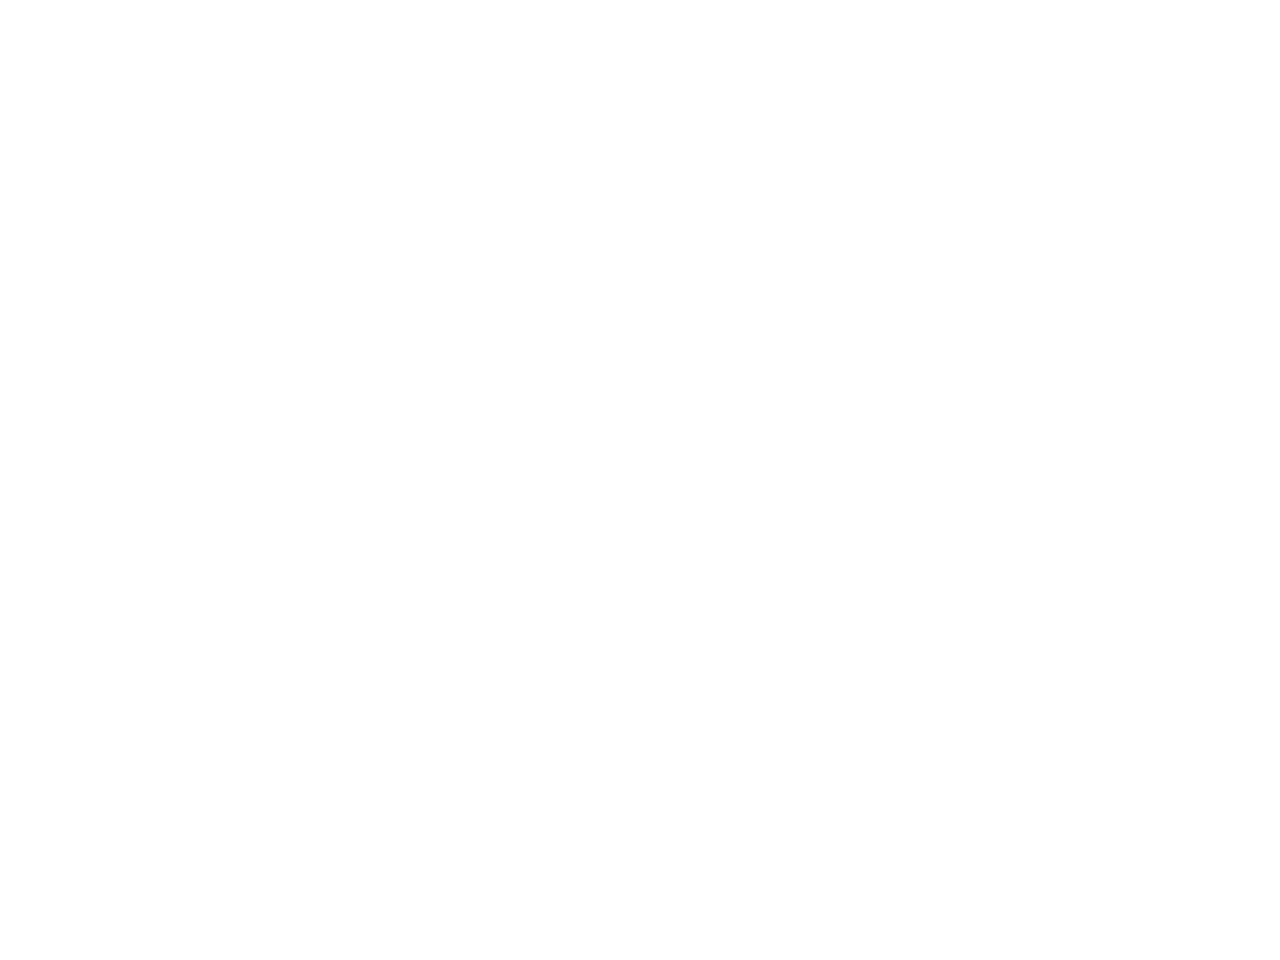

<IPython.core.display.Javascript object>


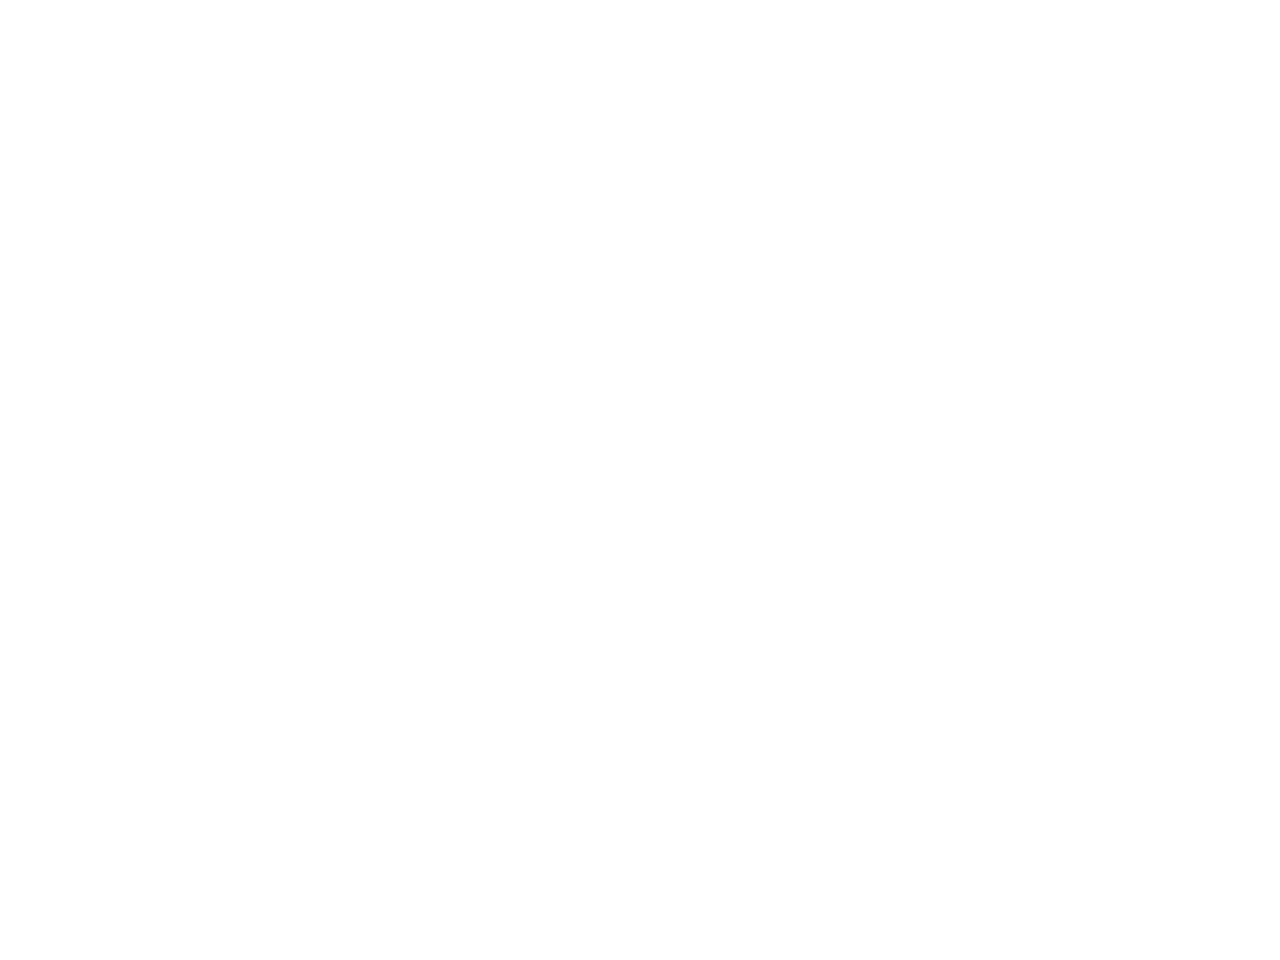

<IPython.core.display.Javascript object>


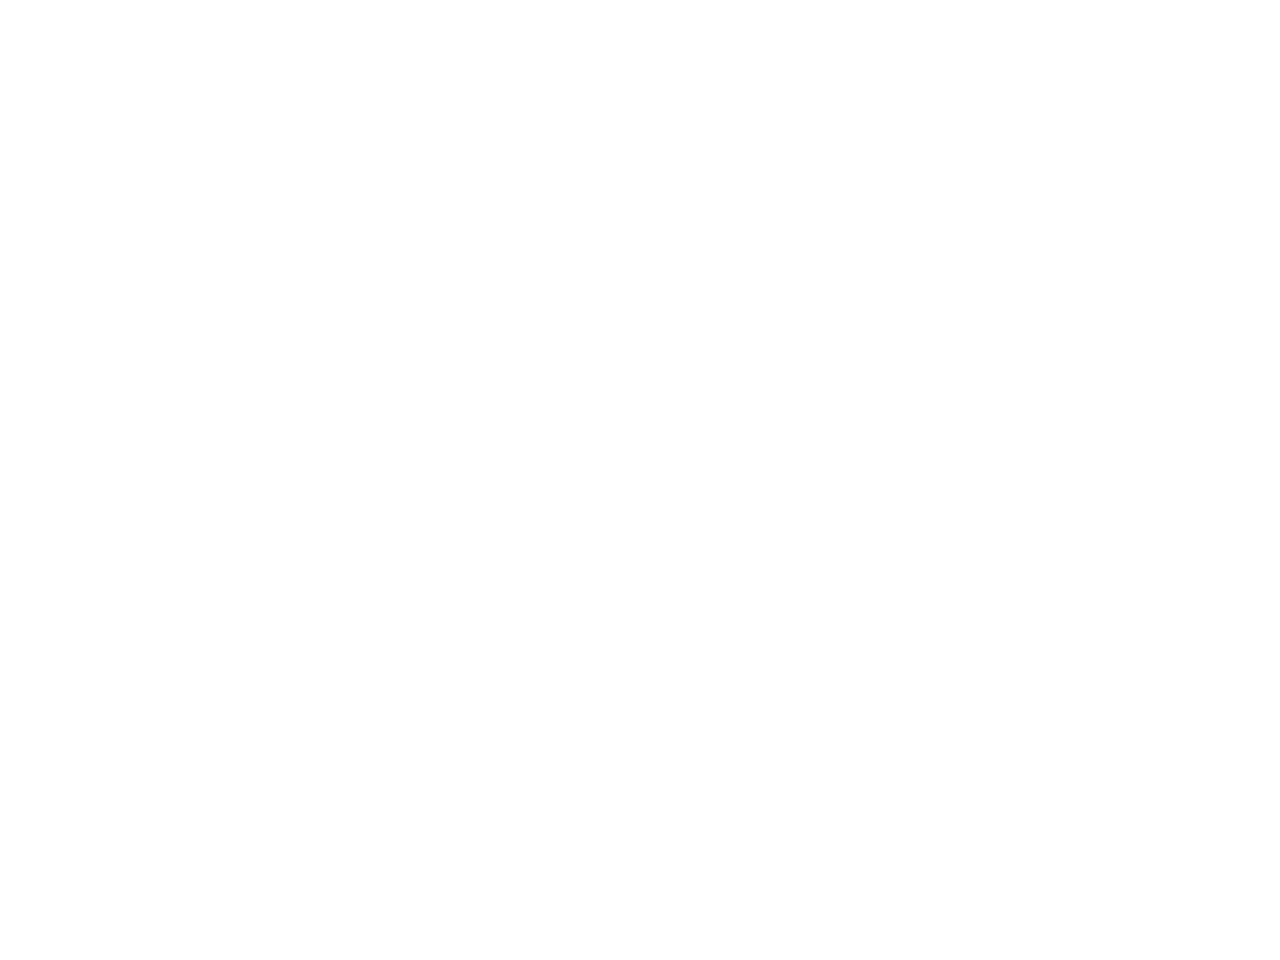

<IPython.core.display.Javascript object>


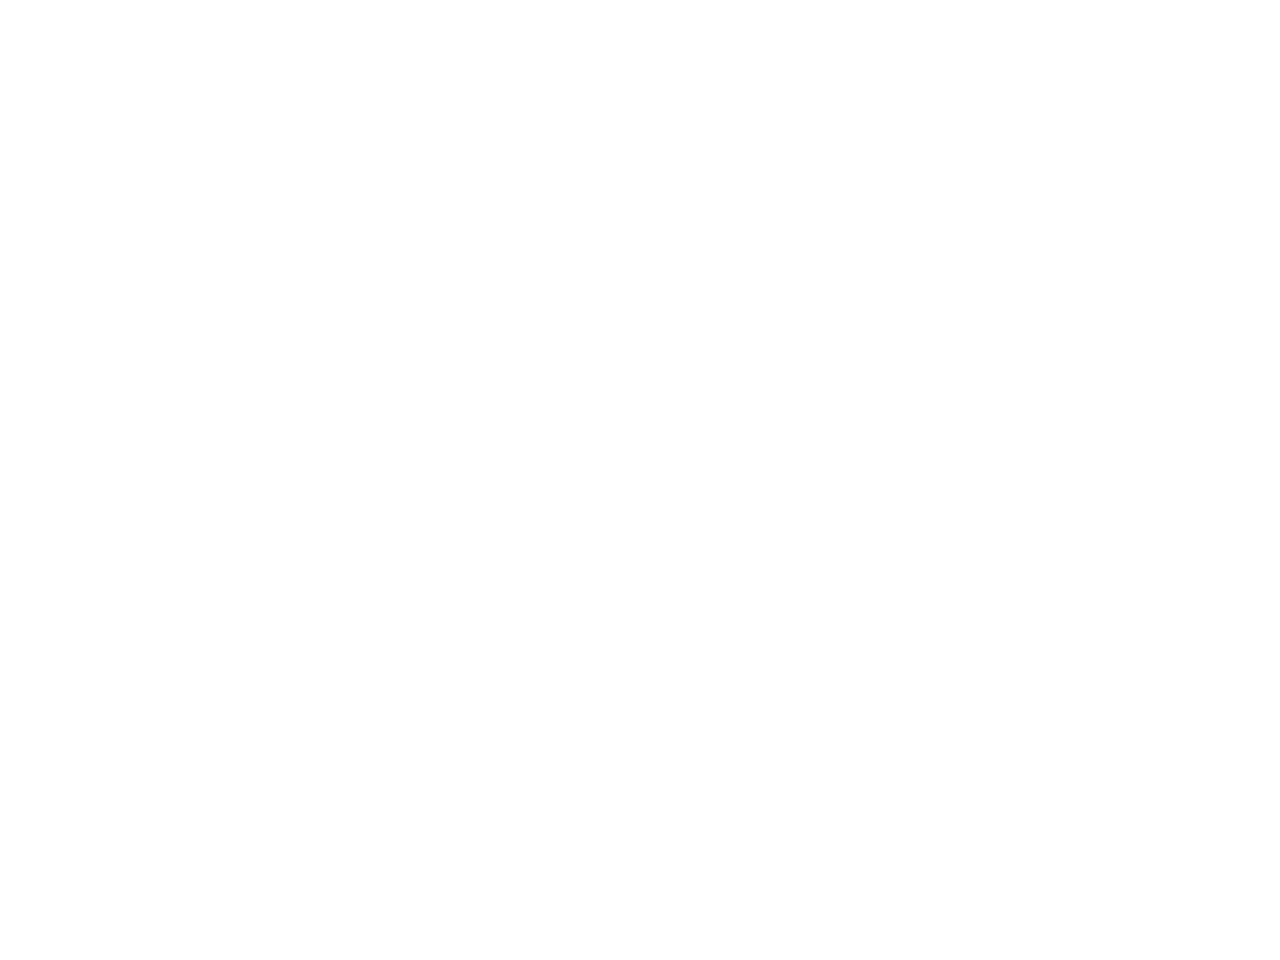

<IPython.core.display.Javascript object>


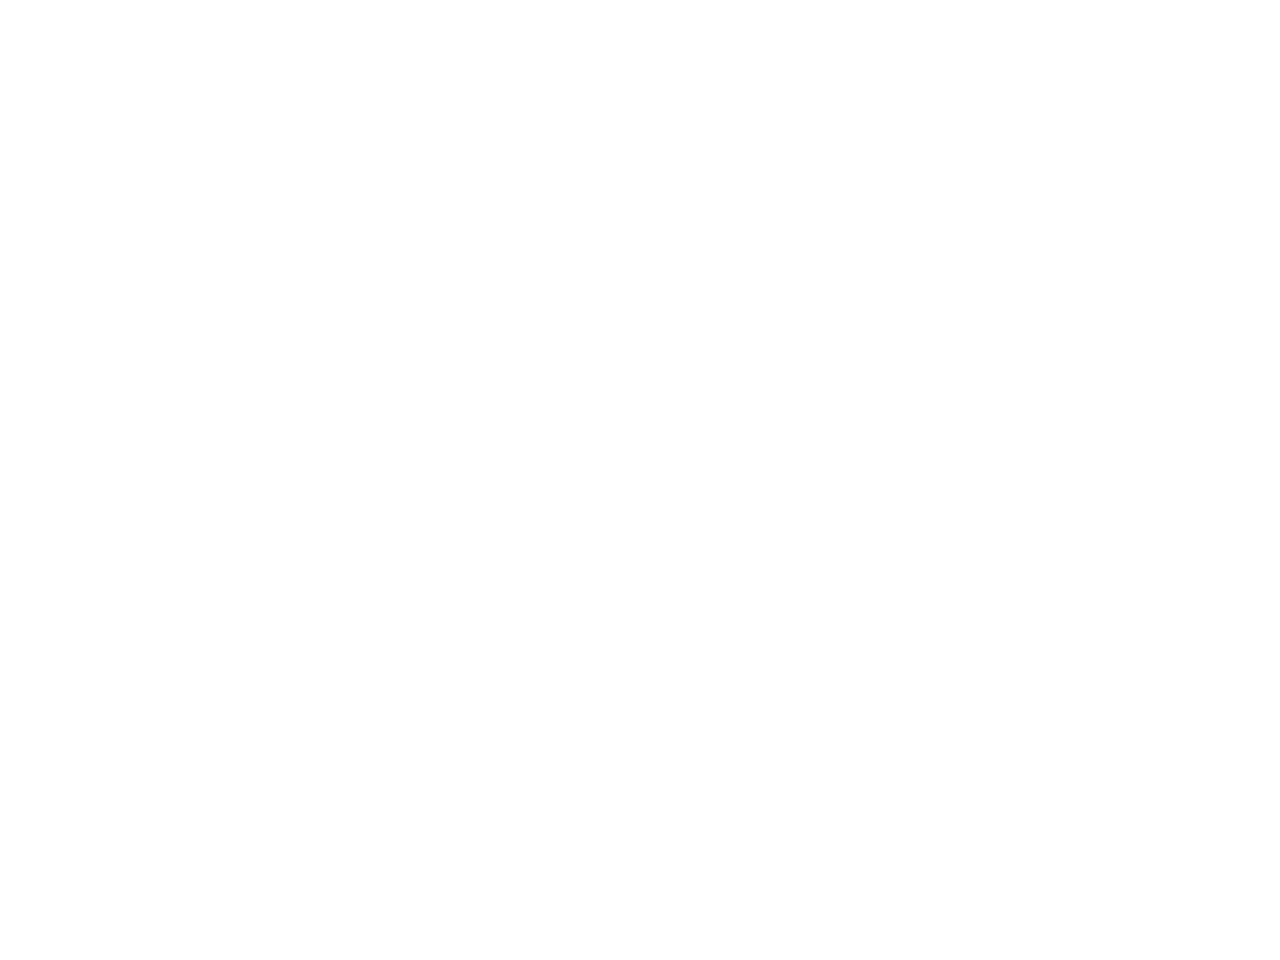

In [65]:
plot_data =[]

#plt.figure(figsize=(15,5))
for idx in dp_idx:
    bond_1=bond_list[2*(idx//2),1]
    bond_2=bond_list[2*(idx//2)+1,1] 
    
    dps = [bond_1,bond_2,bond_1+bond_2,bond_1-bond_2]
    
    plot_data =[]
    for temp_data in dps:
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.sqrt(17/9)*np.fft.fftfreq(n, d=timestep)

        w_length = (freq*1e12)/light_c #
        fqnew = np.linspace(0, freq.max(), 300)
        w_length_plot = np.linspace(2500,4500,300)
        res_data = np.zeros(w_length_plot.shape)
        for dp_x,dp_y in zip(w_length,ps):
            res_data+=dp_y.real*gaussian(w_length_plot,dp_x,50*dp_y.real)/len(bond_list[idx,-1])
    
        plot_data.append([w_length_plot, res_data])
    tags = ['b1','b2','sum','diff']
    for tag,pdata in zip(tags,plot_data):
        plt.plot(pdata[0], pdata[1], lw=2,label=tag)
    plt.xlim(2500,4500)
    #plt.ylim(0,0.002)
    plt.legend()
    plt.savefig('lifetime_'+str(len(bond_list[idx,1]))+'.png')
    plt.close()

In [59]:
!pwd

/rhome/wzhan097/bigdata/woochul


In [ ]:


#plt.figure(figsize=(15,5))
x_int = np.linspace(2500,4500, 20000)
y_int = np.zeros(x_int.shape,dtype='float64')
for idx in range(len(period_len)):
    temp_data=bond_list[idx,1]  
    vel = temp_data[1:]-temp_data[:-1]
    fft = np.fft.fft(vel)
    ps = fft*np.conjugate(fft)
    acf = np.fft.ifft(ps)

    signal = vel
    fourier = np.fft.fft(signal)
    n = signal.size
    timestep = 1E-3
    freq = 2*np.sqrt(17/9)*np.fft.fftfreq(n, d=timestep)
    w_length_plot = np.linspace(2500,4500,300)
    w_length = (freq*1e12)/light_c #
    fqnew = np.linspace(0, freq.max(), 300)
    f = interpolate.interp1d(w_length, ps, kind="cubic")
    y_int+=np.array(f(x_int),dtype='float64')


from scipy import interpolate
#plot_data = np.array(plot_data)
#plot_data.sort(key=lambda x: x[0])
#f = interpolate.interp1d(plot_data[0], plot_data[1], kind="cubic")
#x_int = np.linspace(2500,4500, 20000)
plt.plot(x_int,f(x_int))
plt.xlim(2500,4500)
plt.savefig('plot/DDAA/'+'RT_02_all'+'.png')

In [11]:
def gaussian(x,mu,sig):
    return np.exp(-((x-mu)**2)/(2*sig**2))

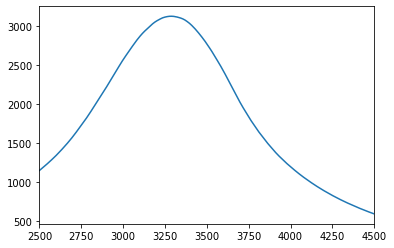

In [61]:
from scipy import interpolate
#plt.figure(figsize=(15,5))
x_int = np.linspace(2500, 4500, 20000)
y_int = np.zeros(x_int.shape,dtype='float64')

w_length_plot = np.linspace(2500,4500,300)
    
res_data = np.zeros(w_length_plot.shape)
for idx in range(len(period_len)):#range(len(period_len)):
    temp_data=bond_list[idx,1]  
    vel = temp_data[1:]-temp_data[:-1]
    fft = np.fft.fft(vel)
    ps = fft*np.conjugate(fft)
    acf = np.fft.ifft(ps)

    signal = vel #divide by maximum abs(vel)
    fourier = np.fft.fft(signal)
    n = signal.size
    timestep = 1E-3
    freq = 2*np.sqrt(17/9)*np.fft.fftfreq(n, d=timestep)

    w_length = (freq*1e12)/light_c #
    for dp_x,dp_y in zip(w_length,ps):
        res_data+=dp_y.real*gaussian(w_length_plot,dp_x,50*dp_y.real)
    
plt.plot(w_length_plot,res_data,label='plot/DDAA/'+'RT_02')
plt.xlim(2500,4500)
#plt.legend()
data_DDAA_RT = res_data
plt.savefig('plot/DA/'+'RT_02_allinone'+'.png')



In [12]:
def temp_get_data(sys_ind = '00',Tem = 'RT',temp_tag='_02',water_form = 'water-DDAA',w_length_plot = np.linspace(2500,4500,300)):
    
    light_c = 29979245800
    
    mol_type_time = np.load(sys_ind+'/'+Tem+"_O_form"+temp_tag+".npy")

    period,_ = water_form_lifetime(mol_type_time, water_form = water_form)
    Os = if_OH_bond = np.load(sys_ind+'/'+Tem+"_O_inds"+temp_tag+".npy")


    angles_tag = []
    for i in set(Os):
        n = len(np.where(Os==i)[0])
        _n = 0
        for _i in range(n):
            _n+=_i
        angles_tag +=[i]*_n
    angles_tag = np.array(angles_tag)

    outfile = sys_ind+'/'+Tem+"_OH_flg"+temp_tag+".npy"
    if_OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH_flg"+temp_tag+".npy"
    if_HOH_angle = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_OH"+temp_tag+".npy"
    OH_bond = np.load(outfile)
    outfile = sys_ind+'/'+Tem+"_HOH"+temp_tag+".npy"
    HOH_angle = np.load(outfile)
    bond_mat = []
    angle_mat = []
    bond_list = []
    angle_list = []
    for i,ps in enumerate(period):
        #print(i)
        for p in ps:
            _flg = if_OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _bondL =  OH_bond[p[0]:p[1],np.where(Os==i)[0]]
            _i = np.where(_flg[0]==1)[0]

            for l in _bondL[:,_i].T:
                bond_list.append([i,l])

            _flg = if_HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _angleA =  HOH_angle[p[0]:p[1],np.where(angles_tag==i)[0]]
            _i = np.where(_flg[0]==1)[0]
            for l in _angleA[:,_i].T:
                angle_list.append([i,l])
                
    x_int = np.linspace(2500, 4500, 20000)
    y_int = np.zeros(x_int.shape,dtype='float64')

    bond_list = np.array(bond_list)
    res_data = np.zeros(w_length_plot.shape)
    for idx in range(len(bond_list)):#range(len(period_len)):
        temp_data=bond_list[idx,1]  
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel #divide by maximum abs(vel)
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.sqrt(17/9)*np.fft.fftfreq(n, d=timestep)

        w_length = (freq*1e12)/light_c #
        for dp_x,dp_y in zip(w_length,ps):
            res_data+=dp_y.real*gaussian(w_length_plot,dp_x,10*dp_y.real)#/len(bond_list[idx,-1])
    
    angle_list = np.array(angle_list)
    res_data_ang = np.zeros(w_length_plot.shape)
    
    for idx in range(len(angle_list)):#range(len(period_len)):
        temp_data=angle_list[idx,1]  
        vel = temp_data[1:]-temp_data[:-1]
        fft = np.fft.fft(vel)
        ps = fft*np.conjugate(fft)
        acf = np.fft.ifft(ps)

        signal = vel #divide by maximum abs(vel)
        fourier = np.fft.fft(signal)
        n = signal.size
        timestep = 1E-3
        freq = 2*np.sqrt(17/9)*np.fft.fftfreq(n, d=timestep)

        w_length = (freq*1e12)/light_c #
        for dp_x,dp_y in zip(w_length,ps):
            res_data_ang+=dp_y.real*gaussian(w_length_plot,dp_x,10*dp_y.real)#/len(angle_list[idx,-1])
            
    bond_list = np.array(bond_list)
    period_len = np.array([len(e) for e in bond_list[:,-1]])
    #plt.plot(w_length_plot,res_data,label='plot/DDAA/'+'RT_02')
    #plt.xlim(2500,4500)
    return res_data/sum(period_len), res_data_ang/sum(np.array([len(e) for e in bond_list[:,-1]]))
    return res_data, res_data_ang




In [26]:
x,y = temp_get_data(sys_ind = '00',Tem = 'RT',temp_tag='_02',water_form = 'water-DDAA')


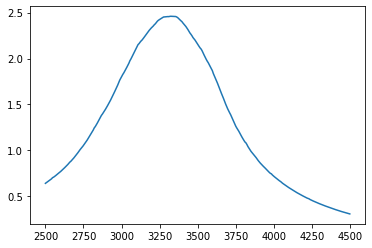

In [24]:
w_length_plot = np.linspace(2500,4500,300)
plt.plot(w_length_plot,x)

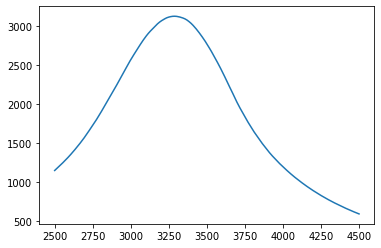

In [27]:
w_length_plot = np.linspace(2500,4500,300)
plt.plot(w_length_plot,x)

00/LT/water-DA
00/LT/water-DAA
00/LT/water-DDA
00/LT/water-DDAA
00/LT/hydronium-AAA
00/RT/water-DA
00/RT/water-DAA
00/RT/water-DDA
00/RT/water-DDAA
00/RT/hydronium-AAA


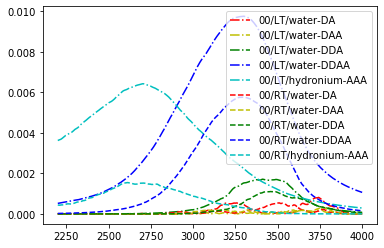

01/LT/water-DA
01/LT/water-DAA
01/LT/water-DDA
01/LT/water-DDAA
01/LT/hydronium-AAA
01/RT/water-DA
01/RT/water-DAA
01/RT/water-DDA
01/RT/water-DDAA
01/RT/hydronium-AAA


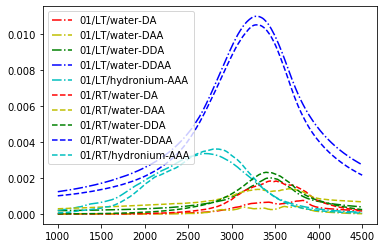

02/LT/water-DA
02/LT/water-DAA
02/LT/water-DDA
02/LT/water-DDAA
02/LT/hydronium-AAA
02/RT/water-DA
02/RT/water-DAA
02/RT/water-DDA
02/RT/water-DDAA
02/RT/hydronium-AAA


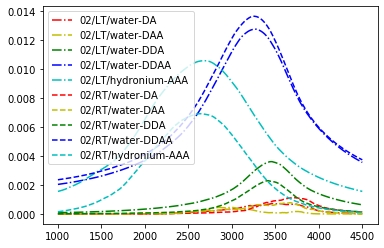

03/LT/water-DA
03/LT/water-DAA
03/LT/water-DDA
03/LT/water-DDAA
03/LT/hydronium-AAA
03/RT/water-DA
03/RT/water-DAA
03/RT/water-DDA
03/RT/water-DDAA
03/RT/hydronium-AAA


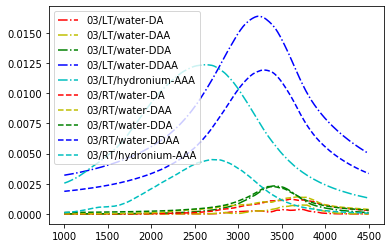

04/LT/water-DA
04/LT/water-DAA
04/LT/water-DDA
04/LT/water-DDAA
04/LT/hydronium-AAA
04/RT/water-DA
04/RT/water-DAA
04/RT/water-DDA
04/RT/water-DDAA
04/RT/hydronium-AAA


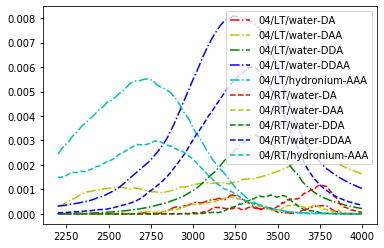

05/LT/water-DA
05/LT/water-DAA
05/LT/water-DDA
05/LT/water-DDAA
05/LT/hydronium-AAA
05/RT/water-DA
05/RT/water-DAA
05/RT/water-DDA
05/RT/water-DDAA
05/RT/hydronium-AAA


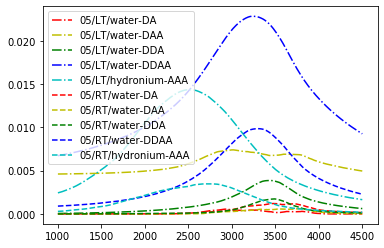

06/LT/water-DA
06/LT/water-DAA
06/LT/water-DDA
06/LT/water-DDAA
06/LT/hydronium-AAA
06/RT/water-DA
06/RT/water-DAA
06/RT/water-DDA
06/RT/water-DDAA
06/RT/hydronium-AAA


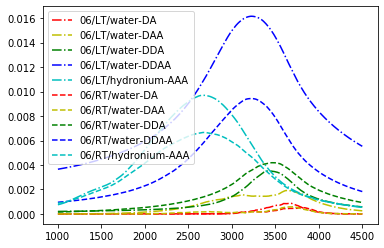

In [55]:
res = [[],[],[],[],[],[]]
res_ang = [[],[],[],[],[],[]]
w_length_plot = np.linspace(1000,4500,500)
colors = ['r','y','g','b','c']
marker = ['-.','--']
for sys_id in range(0,7):
    for t, e in enumerate(['LT','RT']):
        for c, water in enumerate(['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']):
            print('0'+str(sys_id)+'/'+e+'/'+water)
            '''
            x, ang_x = temp_get_data(sys_ind = '0'+str(sys_id),Tem = e ,temp_tag='_02',water_form = water,w_length_plot = w_length_plot)
            plt.plot(w_length_plot,x,label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            temp = np.zeros((3,len(w_length_plot)))
            temp[0] = np.array(w_length_plot)
            temp[1] = np.array(x)
            temp[2] = np.array(ang_x)
            np.save('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy',temp)
            '''
            data = np.load('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy')
            plt.plot(data[0],data[1],label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            #res[sys_id].append(x)
            #res_ang[sys_id].append(ang_x)
    plt.legend()
    plt.show()

06/RT/water-DA
06/RT/water-DAA
06/RT/water-DDA
06/RT/water-DDAA
06/RT/hydronium-AAA


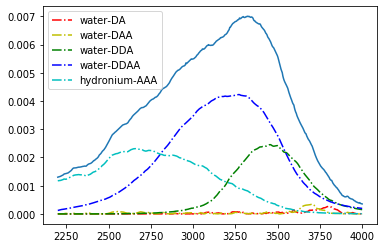

In [13]:
res = [[],[],[],[],[],[]]
res_ang = [[],[],[],[],[],[]]
w_length_plot = np.linspace(2200,4000,500)
colors = ['r','y','g','b','c','black']
marker = ['-.','--']
for sys_id in range(6,7):
    for t, e in enumerate(['RT']):
        data_all = np.zeros(w_length_plot.shape)
        for c, water in enumerate(['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']):
            print('0'+str(sys_id)+'/'+e+'/'+water)
            
            x, ang_x = temp_get_data(sys_ind = '0'+str(sys_id),Tem = e ,temp_tag='_02',water_form = water,w_length_plot = w_length_plot)
            #plt.plot(w_length_plot,x,label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            plt.plot(w_length_plot,x, label=water, color=colors[c],linestyle=marker[t])

            temp = np.zeros((3,len(w_length_plot)))
            temp[0] = np.array(w_length_plot)
            temp[1] = np.array(x)
            temp[2] = np.array(ang_x)
            data_all+=x
            np.save('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy',temp)
            '''
            data = np.load('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy')
            
            plt.plot(data[0],data[1],label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            '''
        plt.plot(w_length_plot,data_all)
    plt.legend()
    plt.show()

In [ ]:
res = [[],[],[],[],[],[]]
res_ang = [[],[],[],[],[],[]]
w_length_plot = np.linspace(2200,4000,500)
colors = ['r','y','g','b','c','black']
marker = ['-.','--']
for sys_id in range(6,7):
    for t, e in enumerate(['LT']):
        data_all = np.zeros(w_length_plot.shape)
        for c, water in enumerate(['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']):
            print('0'+str(sys_id)+'/'+e+'/'+water)
            
            x, ang_x = temp_get_data(sys_ind = '0'+str(sys_id),Tem = e ,temp_tag='_02',water_form = water,w_length_plot = w_length_plot)
            #plt.plot(w_length_plot,x,label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            plt.plot(w_length_plot,x, label=water, color=colors[c],linestyle=marker[t])

            temp = np.zeros((3,len(w_length_plot)))
            temp[0] = np.array(w_length_plot)
            temp[1] = np.array(x)
            temp[2] = np.array(ang_x)
            data_all+=x
            np.save('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy',temp)
            '''
            data = np.load('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy')
            
            plt.plot(data[0],data[1],label='0'+str(sys_id)+'/'+e+'/'+water, color=colors[c],linestyle=marker[t])
            '''
        plt.plot(w_length_plot,data_all)
    plt.legend()
    plt.show()

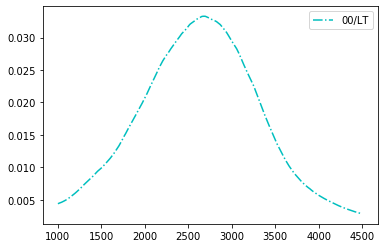

In [34]:
plt.plot(data[0],data_all[1],label='0'+str(sys_id)+'/'+e, color=colors[c],linestyle=marker[t])
plt.legend()
plt.show()

00/LT/water-DA
00/LT/water-DAA
00/LT/water-DDA
00/LT/water-DDAA
00/LT/hydronium-AAA
00/RT/water-DA
00/RT/water-DAA
00/RT/water-DDA
00/RT/water-DDAA
00/RT/hydronium-AAA


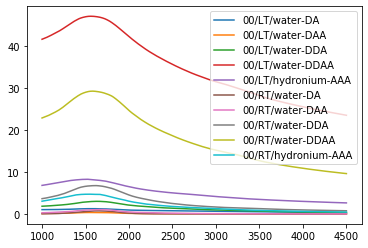

01/LT/water-DA
01/LT/water-DAA
01/LT/water-DDA
01/LT/water-DDAA
01/LT/hydronium-AAA
01/RT/water-DA
01/RT/water-DAA
01/RT/water-DDA
01/RT/water-DDAA
01/RT/hydronium-AAA


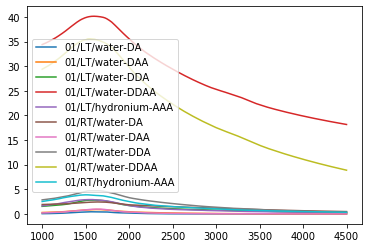

02/LT/water-DA
02/LT/water-DAA
02/LT/water-DDA
02/LT/water-DDAA
02/LT/hydronium-AAA
02/RT/water-DA
02/RT/water-DAA
02/RT/water-DDA
02/RT/water-DDAA
02/RT/hydronium-AAA


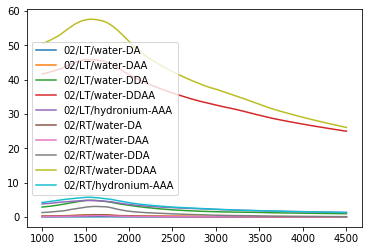

03/LT/water-DA
03/LT/water-DAA
03/LT/water-DDA
03/LT/water-DDAA
03/LT/hydronium-AAA
03/RT/water-DA
03/RT/water-DAA
03/RT/water-DDA
03/RT/water-DDAA
03/RT/hydronium-AAA


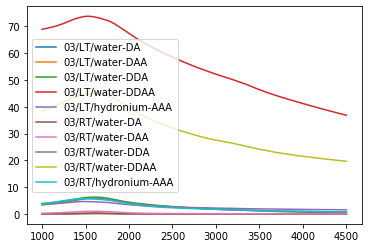

04/LT/water-DA
04/LT/water-DAA
04/LT/water-DDA
04/LT/water-DDAA
04/LT/hydronium-AAA
04/RT/water-DA
04/RT/water-DAA
04/RT/water-DDA
04/RT/water-DDAA
04/RT/hydronium-AAA


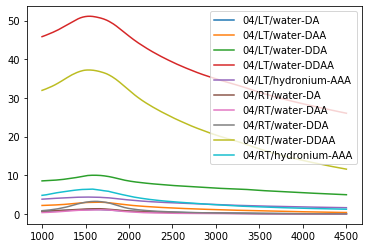

05/LT/water-DA
05/LT/water-DAA
05/LT/water-DDA
05/LT/water-DDAA
05/LT/hydronium-AAA
05/RT/water-DA
05/RT/water-DAA
05/RT/water-DDA
05/RT/water-DDAA
05/RT/hydronium-AAA


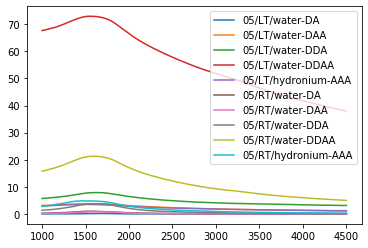

06/LT/water-DA
06/LT/water-DAA
06/LT/water-DDA
06/LT/water-DDAA
06/LT/hydronium-AAA
06/RT/water-DA
06/RT/water-DAA
06/RT/water-DDA
06/RT/water-DDAA
06/RT/hydronium-AAA


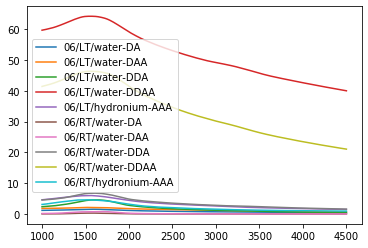

In [36]:
for sys_id in range(0,7):
    for e in ['LT','RT']:
        for water in ['water-DA','water-DAA','water-DDA','water-DDAA','hydronium-AAA']:
            print('0'+str(sys_id)+'/'+e+'/'+water)
            data = np.load('H3PO4-vib/'+'/0'+str(sys_id)+'/'+e+'/'+water+'_x-bond-ang.npy')
            plt.plot(data[0],data[2],label='0'+str(sys_id)+'/'+e+'/'+water)
            #res[sys_id].append(x)
            #res_ang[sys_id].append(ang_x)
    plt.legend()
    plt.show()

In [36]:
res_LT = res[0][:4]
res_RT = res[0][4:]
res_ang_LT = res_ang[0][:4]
res_ang_RT = res_ang[0][4:]

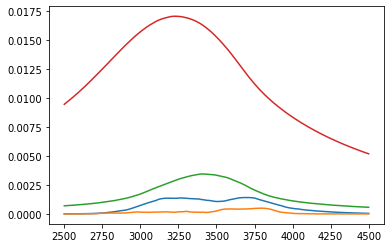

In [112]:
for e in res_LT:
    plt.plot(w_length_plot,e)
plt.show()

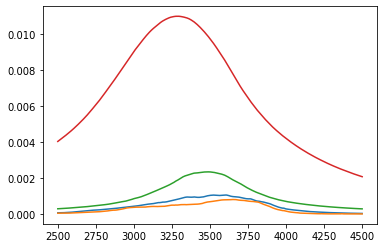

In [113]:
for e in res_RT:
    plt.plot(w_length_plot,e)
plt.show()

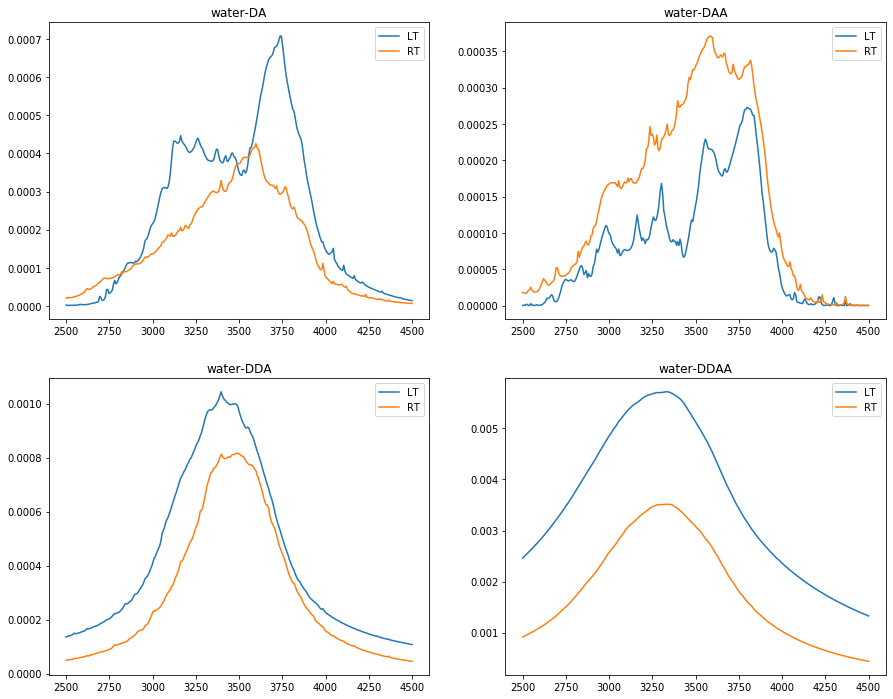

In [41]:
fig,_ = plt.subplots(2, 2, figsize = (15, 12))

ax1 = plt.subplot(221)
ax1.plot(w_length_plot,res_LT[0],label = 'LT')
ax1.plot(w_length_plot,res_RT[0],label = 'RT')
ax1.set_title('water-DA')
ax2 = plt.subplot(222)
ax2.plot(w_length_plot,res_LT[1],label = 'LT')
ax2.plot(w_length_plot,res_RT[1],label = 'RT')
ax2.set_title('water-DAA')
ax3 = plt.subplot(223)
ax3.plot(w_length_plot,res_LT[2],label = 'LT')
ax3.plot(w_length_plot,res_RT[2],label = 'RT')
ax3.set_title('water-DDA')
ax4 = plt.subplot(224)
ax4.plot(w_length_plot,res_LT[3],label = 'LT')
ax4.plot(w_length_plot,res_RT[3],label = 'RT')
ax4.set_title('water-DDAA')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

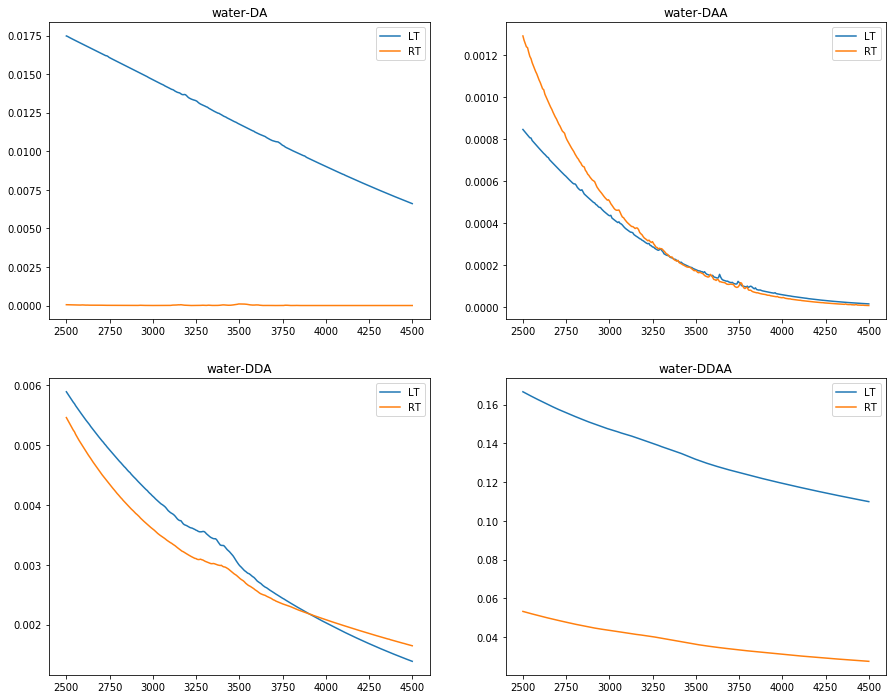

In [42]:
fig,_ = plt.subplots(2, 2, figsize = (15, 12))

ax1 = plt.subplot(221)
ax1.plot(w_length_plot,res_ang_LT[0],label = 'LT')
ax1.plot(w_length_plot,res_ang_RT[0],label = 'RT')
ax1.set_title('water-DA')
ax2 = plt.subplot(222)
ax2.plot(w_length_plot,res_ang_LT[1],label = 'LT')
ax2.plot(w_length_plot,res_ang_RT[1],label = 'RT')
ax2.set_title('water-DAA')
ax3 = plt.subplot(223)
ax3.plot(w_length_plot,res_ang_LT[2],label = 'LT')
ax3.plot(w_length_plot,res_ang_RT[2],label = 'RT')
ax3.set_title('water-DDA')
ax4 = plt.subplot(224)
ax4.plot(w_length_plot,res_ang_LT[3],label = 'LT')
ax4.plot(w_length_plot,res_ang_RT[3],label = 'RT')
ax4.set_title('water-DDAA')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

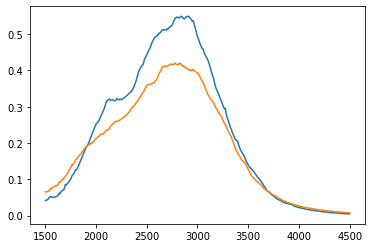

In [26]:
w_length_plot = np.linspace(1500,4500,500)
x, ang_x = temp_get_data(sys_ind = '0'+str(1),Tem = 'RT' ,temp_tag='_02',water_form = 'hydronium-AAA',w_length_plot = w_length_plot)
plt.plot(w_length_plot,x,label='0'+str(1)+'/'+'RT'+'/'+'hydronium-AAA')
x, ang_x = temp_get_data(sys_ind = '0'+str(1),Tem = 'LT' ,temp_tag='_02',water_form = 'hydronium-AAA',w_length_plot = w_length_plot)
plt.plot(w_length_plot,x,label='0'+str(1)+'/'+'LT'+'/'+'hydronium-AAA')
plt.show()

In [ ]:
res = [[],[],[],[],[],[]]
res_ang = [[],[],[],[],[],[]]
for sys_id in range(0,1):
    for e in ['LT','RT']:
        for water in ['water-DA','water-DAA','water-DDA','water-DDAA']:
            print('0'+str(sys_id)+'/'+e+'/'+water)
            x, ang_x = temp_get_data(sys_ind = '0'+str(sys_id),Tem = e ,temp_tag='_02',water_form = water)
            plt.plot(w_length_plot,x,label='0'+str(sys_id)+'/'+e+'/'+water)
            res[sys_id].append(x)
            res_ang[sys_id].append(ang_x)
plt.legend()
plt.show()

In [ ]:
import subprocess

data_path = '/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp/04'
filename = 'output.log'
bashCommand = "grep ' E=' " + os.path.join(data_path, filename)
lines = subprocess.check_output(bashCommand, shell=True)
lines = str(lines)[2:].split('\\n')[:-1]
lines = [[e.split()[0], e.split()[2],e.split()[4]]for e in lines]
lines = np.array([[float(e) for e in l] for l in lines])
plt.scatter(lines[:150,0],lines[:150,2])

In [29]:
import subprocess

data_path = '/rhome/wzhan097/bigdata/proton_battery/LiCl/20p_mass/lammps/01_long'
filename = 'log.lammps'
with open(os.path.join(data_path,filename),'r') as f:
    lines = f.readlines()
#lines = [e.split() for e in lines if len(e.split())==9]

In [30]:
lines = [e.split() for e in lines if len(e.split())==9]

In [31]:
lines = [[float(e) for e in line] for line in lines if line[0].isnumeric()]

In [32]:
lines = np.array(lines)

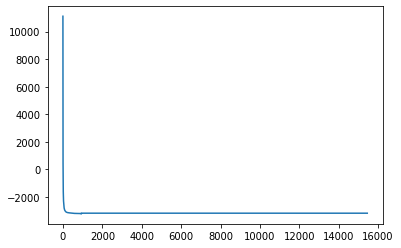

In [19]:
plt.plot(lines[:,0],lines[:,1])

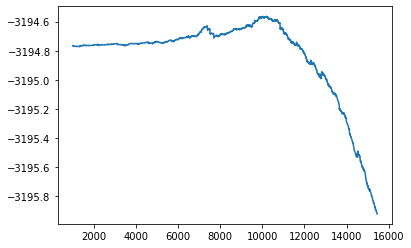

In [22]:
plt.plot(lines[1000:,0],lines[1000:,1])

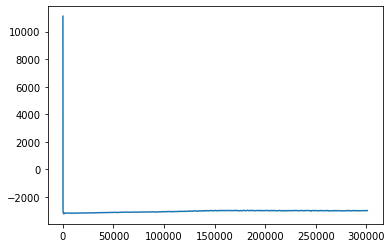

In [33]:
plt.plot(lines[:,0],lines[:,1])

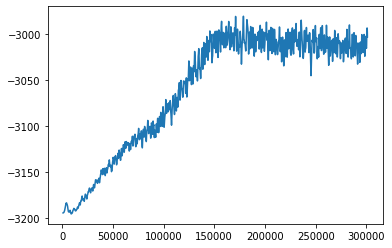

In [34]:
plt.plot(lines[1000:,0],lines[1000:,1])

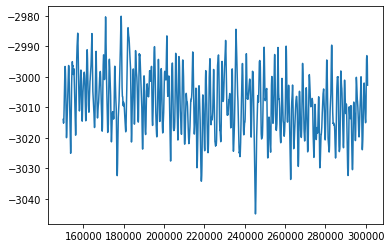

In [36]:
plt.plot(lines[150000:,0],lines[150000:,1])

In [60]:
def O_Odis(Tem = 'RT',sys_ind = '1',temp_tag='_01'):
    Tem_tag = '' #'_RT' for RT

    if Tem == 'RT':
        Tem_tag = '_RT'
    data_path = '/rhome/wzhan097/shared/H3PO4_Weiyi/new_vasp'+Tem_tag+'/0'+sys_ind
    filename = 'CONTCAR'
    ###
    #Reading File
    ###

    with open(os.path.join(data_path,filename),'r') as f:
        lines = f.readlines()
    box = lines[2:5]
    box =[e.split() for e in box]
    box = [box[0][0],box[1][1],box[2][2]]
    box = [float(e) for e in box]
    lines = lines[5:]
    types = lines[0].split()
    temp = lines[1].split()
    temp = [int(e) for e in temp]
    eles = []
    atom_num = sum(temp)

    for _i,_j in zip(types, temp):
        eles = eles+[[_i]]*_j
    eles = np.array(eles, dtype = 'object')
    lines = lines[2:]
    
    
    pos = [[float(_e) for _e in e.split()] for e in lines[1:1+atom_num]]
    pos = np.array(pos, dtype = 'object')
    atoms = np.concatenate((eles, pos),axis=1)

    for i in range(len(box)):
        atoms[:,i+1] = atoms[:,i+1]*box[i]

    Oinds = np.where(atoms[:,0]=='O')[0]
    Hinds = np.where(atoms[:,0]=='H')[0]
    
    O_pos = atoms[Oinds,1:]
    
    res = []
    for i, e in enumerate(O_pos): 
        #print(np.concatenate((O_pos[:i],O_pos[i+1:])))
        temp = distance(box, e, np.concatenate((O_pos[:i],O_pos[i+1:])))
        res = np.concatenate((res,temp))
    return res

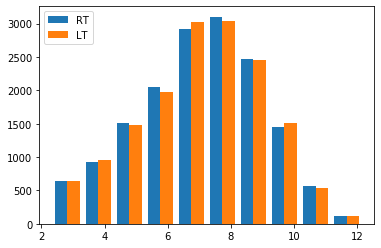

In [63]:
x1,x2 = O_Odis(Tem = 'RT',sys_ind = '4'),O_Odis(Tem = 'LT',sys_ind = '4',temp_tag='_01')
plt.hist([x1,x2],bins=10,label=['RT','LT'])
plt.legend(loc='upper left')
plt.show()

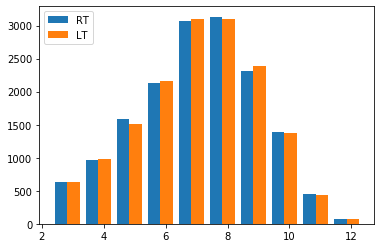

In [64]:
x1,x2 = O_Odis(Tem = 'RT',sys_ind = '0'),O_Odis(Tem = 'LT',sys_ind = '0',temp_tag='_01')
plt.hist([x1,x2],bins=10,label=['RT','LT'])
plt.legend(loc='upper left')
plt.show()